<a href="https://colab.research.google.com/github/Mogarthron/Magazynier/blob/master/PIANKI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PIANKI

In [ ]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sqlalchemy import create_engine, text
engine = create_engine("sqlite:///drive/MyDrive/GENERATORY.db", echo=False)
lista_bryl = dict()
with engine.begin() as conn:
      lb = conn.execute(text(f"SELECT * from lista_bryl_pianki"))
      tab = pd.read_sql(text("SELECT * from baza_PIANKI"), conn)
for i in lb:
  # print(i[0], i[1].split("_"))
  lista_bryl[i[0]] = [x for x in i[1].split("_")]

In [ ]:
lista_bryl["AMALFI"]

['1,5',
 '2,5',
 '3',
 '4',
 '][',
 'NT',
 'N124',
 '[LA',
 '[RS',
 'NW',
 'P102x82',
 'P102x102',
 '1,5 MEM',
 '3,5 MEM',
 'NW MEM',
 'WN MEM',
 '[RS MEM',
 'RS] MEM',
 '[LA MEM',
 'LA] MEM']

In [ ]:
from sqlalchemy import Column, String, Integer, Numeric
# from sqlalchemy.ext.declarative import
from sqlalchemy.orm import sessionmaker, declarative_base
from sqlalchemy import update, insert

Base = declarative_base()

class ZAM_PIANKI(Base):
  __tablename__ = "ZAM_PIANKI"

  lp = Column("LP", Integer, autoincrement=True,  primary_key=True)

  tydzien = Column("TYDZIEN", Integer)
  kod = Column("KOD", String)
  model = Column("MODEL", String)
  nr_kompletacji = Column("NR_KOMPLETACJI", String(5))
  opis = Column("OPIS", String)
  ile_zam = Column("ILE_ZAMOWIONE", Numeric)
  znacznik_dostawcy = Column("ZNACZNIK_DOSTAWCY", String(2))
  galanteria = Column("GALANTERIA", String(1))
  siedziska_HR = Column("SIEDZISKA_HR", String(1))
  leniwa = Column("LENIWA", String(1))
  zam1 = Column("ZAM1", String(7))
  zam2 = Column("ZAM2", String(7))
  uwagi = Column("UWAGI", String)


  potw_dos1 = Column("POTW_DATA_DOS_1", String)
  potw_dos2 = Column("POTW_DATA_DOS_2", String)
  data_dos1 = Column("DATA_DOSTARCZENIA_1", String(10))
  data_dos2 = Column("DATA_DOSTARCZENIA_2", String(10))

  status_leniwa = Column("STATUS_LENIWA", String(30))
  status_leniwa_skoks = Column("STATUS_LENIWA_SKOSOWANIE", String(30))
  status_owaty = Column("STATUS_OWATY", String(30))
  nr_pz = Column("nr_PZ", String)
  nr_pw = Column("nr_PW", String)
  status_kompletacja = Column("STATUS_KOMPLETACJA", String(50))
  nr_samochodu = Column("nr_SAMOCHODU", String(50))

  def __init__(self, tydzien=None, model=None, kod=None, opis=None, ile_zam=None, znacznik_dostawcy=None, galanteria=None, siedziska_HR=None, leniwa=None, nr_kompletacji=None, zam1=None, zam2=None, uwagi=None):
    self.tydzien = tydzien
    self.kod = kod
    self.model = model
    self.nr_kompletacji = nr_kompletacji
    self.opis = opis
    self.ile_zam = ile_zam
    self.znacznik_dostawcy = znacznik_dostawcy
    self.galanteria = galanteria
    self.siedziska_HR = siedziska_HR
    self.leniwa = leniwa
    self.zam1 = zam1
    self.zam2 = zam2
    self.uwagi = uwagi

  def __repr__(self):
    return f"{self.tydzien}, {self.opis}"




Base.metadata.create_all(bind=engine)

Session = sessionmaker(bind=engine)
session = Session()

# ZAM_PIANKI.__table__.drop(session.bind)
# ZAM_PIANKI.__table__.create(session.bind)

In [ ]:
# @title FUNKCJE
def bryla_pianki(MODEL, BRYLA, ile_zam):
  df = tab[(tab.MODEL == MODEL) &(tab.BRYLA == BRYLA)]
  df.ilosc = df.ilosc * ile_zam
  df.ilosc = df.ilosc.astype(np.int32)

  return df

def zestawienie_pianek_modelu(model, bryly):
  lt = list()
  lista_opisowa = list()

  for i in bryly:
    lt.append(bryla_pianki(model, i, bryly[i]))

  pianki = pd.concat(lt).groupby("NUMER").sum().reset_index()[["NUMER", "ilosc"]]

  def vol(N, i):
    _vol = tab[tab.NUMER == N][["WYS", "SZER", "DLUG"]].drop_duplicates()
    return i * _vol["WYS"].values[0] * _vol["SZER"].values[0] * _vol["DLUG"].values[0] / 1000_000_000

  pianki["VOL"] = pianki.apply(lambda x: vol(x.NUMER, x.ilosc), axis=1)


  for n in pianki.NUMER.index:
    t = tab[(tab.MODEL == m) & (tab.NUMER == pianki.NUMER.iloc[n])]
    num = pianki.NUMER.iloc[n]
    typ = t.TYP.unique()[0]
    profil = t.PROFIL.unique()[0]
    ozn = t.OZN.unique()[0]
    opis = t.PRZEZ.unique()[0]
    wymiar = t.WYMIAR.unique()[0]
    bryly = [x for x in t.BRYLA.tolist() if x in list(b.keys())]

    lista_opisowa.append([num,typ,profil,ozn,opis,wymiar,bryly])

  maks = 1
  for i in lista_opisowa:
    if len(i[-1]) > maks:
      maks = len(i[-1])
    # print(len(i[-1]), maks)

  for i in lista_opisowa:
    if len(i[-1]) < maks:
      for _ in range(maks - len(i[-1])):
        i[-1].append(" ")
    # print(i[-1])
  lo_b = [x[-1] for x in lista_opisowa]

  zpm = pianki.merge(pd.concat([pd.DataFrame([x[:-1] for x in lista_opisowa], columns=["NUMER", "TYP", "PROFIL", "OZN", "OPIS", "WYMIAR"]),
            pd.DataFrame(lo_b, columns=[f"br{x}" for x in range(1, maks+1)])],axis=1), how="left", on="NUMER")

  return zpm


In [ ]:
# @title KLASY



class Pianki:

  def __init__(self, MODEL:str, galanteria, siedziska_HR, leniwa, PIANPOL=False):

    self.galanteria = galanteria
    self.siedziska_HR = siedziska_HR
    self.leniwa = leniwa

    self.Model = MODEL
    self.vita_VOL = 0
    self.ciech_VOL = 0
    self.pianpol_VOL = 0

    with engine.begin() as conn:
      query = text(f"SELECT * from baza_PIANKI WHERE MODEL = '{MODEL}'")
      self.tab = pd.read_sql(query, conn)


  def __bryla_pianki(self, BRYLA, ile_zam):
    df = self.tab[self.tab.BRYLA == BRYLA]
    df.ilosc = df.ilosc * ile_zam
    df.ilosc = df.ilosc.astype(np.int32)

    return df

  def zestawienie_pianek_modelu(self, bryly:dict):
    lt = list()
    lista_opisowa = list()

    for i in bryly:
      lt.append(self.__bryla_pianki(i, bryly[i]))

    pianki = pd.concat(lt).groupby("NUMER").sum().reset_index()[["NUMER", "ilosc"]]

    def vol(N, i):
      _vol = self.tab[self.tab.NUMER == N][["WYS", "SZER", "DLUG"]].drop_duplicates()
      return i * _vol["WYS"].values[0] * _vol["SZER"].values[0] * _vol["DLUG"].values[0] / 1000_000_000

    pianki["VOL"] = pianki.apply(lambda x: vol(x.NUMER, x.ilosc), axis=1)

    for n in pianki.NUMER.index:
      t = self.tab[self.tab.NUMER == pianki.NUMER.iloc[n]]
      num = pianki.NUMER.iloc[n]
      typ = t.TYP.unique()[0]
      profil = t.PROFIL.unique()[0]
      ozn = t.OZN.unique()[0]
      opis = t.PRZEZ.unique()[0]
      wymiar = t.WYMIAR.unique()[0]
      #{self.Model[:3]} opis modelu do br poniżej
      br = [f"{self.Model[:3]} {x} {t[t.BRYLA == x].ilosc.values[0]*bryly[x]:.0f}szt" for x in t.BRYLA.tolist() if x in list(bryly.keys())]

      lista_opisowa.append([num,typ,profil,ozn,opis,wymiar,br])

    maks = 1
    for i in lista_opisowa:
      if len(i[-1]) > maks:
        maks = len(i[-1])
      # print(len(i[-1]), maks)

    for i in lista_opisowa:
      if len(i[-1]) < maks:
        for _ in range(maks - len(i[-1])):
          i[-1].append(" ")
      # print(i[-1])
    lo_b = [x[-1] for x in lista_opisowa]

    zpm = pianki.merge(pd.concat([pd.DataFrame([x[:-1] for x in lista_opisowa], columns=["NUMER", "TYP", "PROFIL", "OZN", "OPIS", "WYMIAR"]),
              pd.DataFrame(lo_b, columns=[f"br{x}" for x in range(1, maks+1)])],axis=1), how="left", on="NUMER")

    return zpm

  def __add__(self, other):
      if type(other) == dict:
        return {"VITA": self.vita_VOL + other["VITA"],
                "CIECH": self.ciech_VOL + other["CIECH"],
                "PIANPOL": self.pianpol_VOL + other["PIANPOL"]}

      else:
        return {"VITA": self.vita_VOL + other.vita_VOL,
                "CIECH": self.ciech_VOL + other.ciech_VOL,
                "PIANPOL": self.pianpol_VOL + other.pianpol_VOL}

  def __radd__(self, other):
    return self.__add__(other)



class CIECH(Pianki):

  mod_VOL_ciech = 1
  MODEL = ""
  def __init__(self, b:dict):
    super().__init__(MODEL=self.MODEL)

    self.bryly = {k:v for k,v in b.items() if b[k] != 0}
    self.ciech = self.zestawienie_pianek_modelu(b)


    self.vita_VOL = 0
    self.ciech_VOL = self.ciech.VOL.sum()*self.mod_VOL_ciech

  def __repr__(self):
    return f"{self.MODEL} Vol Ciech: {self.ciech_VOL:.2f}m3"










In [ ]:
lista_bryl["AMALFI"]

['1,5',
 '2,5',
 '3',
 '4',
 '][',
 'NT',
 'N124',
 '[LA',
 '[RS',
 'NW',
 'P102x82',
 'P102x102',
 '1,5 MEM',
 '3,5 MEM',
 'NW MEM',
 'WN MEM',
 '[RS MEM',
 'RS] MEM',
 '[LA MEM',
 'LA] MEM']

In [ ]:
tab[(tab.MODEL == "AMALFI")&(tab.TYP == "G-401")&(tab.BRYLA.isin(["[RS MEM", "RS]", "NW", "WN", "[LA", "LA]"]))]

,MODEL,BRYLA,TYP,PRZEZ,OR,OZN,PROFIL,NUMER,ilosc,WYMIAR,WYS,SZER,DLUG
4393,AMALFI,[RS MEM,G-401,korpus,None,profil,P-180,FA0342,1,50x928x1428,50,928,1428
4394,AMALFI,[RS MEM,G-401,korpus,None,profil,P-181,FA0343,1,50x925x976,50,925,976


In [ ]:
# @title KLASY PIANEK M1
class MODEL1(Pianki):
  """
  MODEL1 rozdziału pianek na siediska HR-3020 vita reszta ciech
  bm -> bryły z analizy
  bg -> bryły z generatora
  """
  mod_VOL_ciech = 1
  mod_VOL_vita = 1
  MODEL = ""

  def __init__(self, b=None):
    super().__init__(MODEL=self.MODEL, galanteria="C", siedziska_HR="V", leniwa="C")



    if type(b) == dict:
      self.bryly = {k:v for k,v in b.items()}# if b[k] != 0}
      self.BRYLY_ZAM = "BRAK BRYŁ Z ANALIZY"

    elif type(b) == pd.DataFrame:
      print("DOROBIC LOGIKE!!")

    self.zpm = self.zestawienie_pianek_modelu(b)

    filtr_vita = (self.zpm.TYP == "HR-3020") & (self.zpm.OPIS == "siedzisko")

    self.vita = self.zpm[filtr_vita]
    self.ciech = self.zpm[~filtr_vita]
    self.vita_VOL = self.vita.VOL.sum()*self.mod_VOL_vita
    self.ciech_VOL = self.ciech.VOL.sum()*self.mod_VOL_ciech
    self.siedziska_VOL = self.vita[self.vita.TYP == "HR-3020"].VOL.sum()

  def __repr__(self):
    return f"{self.MODEL} Vol Vita: {self.vita_VOL:.2f}m3, Vol Ciech: {self.ciech_VOL:.2f}m3"


class AMALFI(MODEL1):

  mod_VOL_ciech = 0.9
  MODEL = "AMALFI"

  def __init__(self, b:dict, b_memory={"NW":0}):
    super().__init__(b=b)

    ama_mem_pianki = tab[(tab.MODEL == "AMALFI")&(tab.TYP == "G-401")&(tab.BRYLA.isin(["[RS", "RS]", "NW", "WN", "[LA", "LA]"]))]

class ELIXIR(MODEL1):
  MODEL = "ELIXIR"
  def __init__(self,b:dict):
    super().__init__(b=b)

class REVERSO(MODEL1):
  MODEL = "REVERSO"
  def __init__(self,b=None):
    super().__init__(b=b)

class WILLOW(MODEL1):
  mod_VOL_ciech = 0.95
  MODEL = "WILLOW"
  def __init__(self, b:dict):
    super().__init__(b=b)

class OXYGEN(MODEL1):
  mod_VOL_ciech = 0.95
  MODEL = "OXYGEN"
  def __init__(self, b:dict):
    super().__init__(b=b)




In [ ]:
# @title KLASY PIANEK M2

class MODEL2(Pianki):
  """
  MODEL2 rozdziału pianek na Memory Ciech reszta Vita
  bm -> btyły z analizy
  bg -> bryły z generatora
  """

  mod_VOL_ciech = 1
  mod_VOL_vita = 1
  MODEL = ""
  converter=dict()
  def __init__(self, bg:dict):
    super().__init__(MODEL=self.MODEL, galanteria="V", siedziska_HR="V", leniwa="C")



    if bg != None:
      b = bg
      self.bryly = {k:v for k,v in b.items() if b[k] != 0}

    self.bryly = {k:v for k,v in b.items() if b[k] != 0}

    self.zpm = self.zestawienie_pianek_modelu(b)

    filtr_vita = (self.zpm.TYP != "G-401")

    self.vita = self.zpm[filtr_vita]
    self.ciech = self.zpm[~filtr_vita]
    self.vita_VOL = self.vita.VOL.sum()*self.mod_VOL_vita
    self.ciech_VOL = self.ciech.VOL.sum()*self.mod_VOL_ciech
    self.siedziska_VOL = self.vita[self.vita.TYP == "HR-3020"].VOL.sum()


  def __repr__(self):
    return f"{self.MODEL} Vol Vita: {self.vita_VOL:.2f}m3, Vol Ciech: {self.ciech_VOL:.2f}m3"



class HORIZON(MODEL2):
  MODEL = "HORIZON"
  def __init__(self,b:dict):
    super().__init__(bg=b)

class LOBBY(MODEL2):
  MODEL = "LOBBY"
  def __init__(self,b:dict):
    super().__init__(bg=b)

class DUO(MODEL2):
  MODEL = "DUO"
  def __init__(self,b:dict):
    super().__init__(bg=b)

class MAXWELL(MODEL2):
  MODEL = "MAXWELL"
  def __init__(self,b:dict):
    super().__init__(bg=b)

class ONYX(MODEL2):
  MODEL = "ONYX"
  def __init__(self,b:dict):
    super().__init__(bg=b)

class COCO(MODEL2):
  MODEL = "COCO"
  def __init__(self,b:dict):
    super().__init__(bg=b)

In [ ]:
# @title KLASY PIANEK M3
#Model rozdziału paneka Memory olta reszta VITA

class MODEL3(Pianki):
  """
  Model3 rozdziału paneka Memory olta reszta VITA
  olta -> zwaraca liste pianek memory do wycięcia w olcie
  """
  mod_VOL_ciech = 1
  mod_VOL_vita = 1
  MODEL = ""

  def __init__(self, b:dict):
    super().__init__(MODEL=self.MODEL, galanteria="V", siedziska_HR="V", leniwa="O")



    self.bryly = b
    self.zpm = self.zestawienie_pianek_modelu(b)

    filtr_model3 = (self.zpm.TYP != "G-401")

    self.vita = self.zpm[filtr_model3]
    self.olta = self.zpm[~filtr_model3]
    self.vita_VOL = self.vita.VOL.sum()*self.mod_VOL_vita
    self.ciech_VOL = 0
    self.siedziska_VOL = self.vita[self.vita.TYP == "HR-3020"].VOL.sum()

  def __repr__(self):
    return f"{self.MODEL} Vol Vita: {self.vita_VOL:.2f}m3"



class STONE(MODEL3):
  MODEL = "STONE"
  def __init__(self,b:dict):
    super().__init__(b=b)

class UNO(MODEL3):
  MODEL = "UNO"
  def __init__(self,b:dict):
    super().__init__(b=b)


In [ ]:
# @title KLASY PIANEK M4

class MODEL4(Pianki):
  """
  MODEL4 komplety brył zamawiane w CIECHU
  bm -> btyły z analizy
  bg -> bryły z generatora
  """

  mod_VOL_ciech = 1
  mod_VOL_vita = 1
  MODEL = ""

  def __init__(self, b:dict):
    super().__init__(MODEL=self.MODEL, galanteria="C", siedziska_HR="C", leniwa="C")

    self.bryly = {k:v for k,v in b.items() if b[k] != 0}

    self.zpm = self.zestawienie_pianek_modelu(b)

    # filtr_vita = (self.zpm.TYP != "G-401")

    self.vita = None
    self.ciech = self.zpm
    self.vita_VOL = 0
    self.ciech_VOL = self.ciech.VOL.sum()*self.mod_VOL_ciech


  def __repr__(self):
    return f"{self.MODEL} Vol Ciech: {self.ciech_VOL:.2f}m3"



class CALYPSO(MODEL4):
  MODEL = "CALYPSO"
  def __init__(self,b:dict):
    super().__init__(b=b)

class DIVA(MODEL4):
  MODEL = "DIVA"
  def __init__(self,b:dict):
    super().__init__(b=b)

class HUDSON(MODEL4):
  MODEL = "HUDSON"
  def __init__(self,b:dict):
    super().__init__(b=b)

class RITZ(MODEL4):
  MODEL = "RITZ"
  def __init__(self,b:dict):
    super().__init__(b=b)

class SAMOA(MODEL4):
  MODEL = "SAMOA"
  def __init__(self,b:dict):
    super().__init__(b=b)

class SPECTRA(MODEL4):
  MODEL = "SPECTRA"
  def __init__(self,b:dict):
    super().__init__(b=b)

class GREY(MODEL4):
  MODEL = "GREY"
  def __init__(self,b:dict):
    super().__init__(b=b)

class LENOX(MODEL4):
  MODEL = "LENOX"
  def __init__(self,b:dict):
    super().__init__(b=b)

In [ ]:
# @title KLASY PIANEK M5

class MODEL5(Pianki):
  """
  MODEL5 komplety brył zamawiane w PIANPOLU BEZ LENIWEJ
  bm -> btyły z analizy
  bg -> bryły z generatora
  """


  MODEL = ""

  def __init__(self, b:dict):
    super().__init__(MODEL=self.MODEL, galanteria="P", siedziska_HR="P", leniwa="O")

    self.bryly = {k:v for k,v in b.items() if b[k] != 0}

    self.zpm = self.zestawienie_pianek_modelu(b)

    filtr_pianpol = (self.zpm.TYP != "G-401")

    self.vita = None
    self.ciech = self.zpm[~filtr_pianpol]
    self.pianpol = self.zpm[filtr_pianpol]
    self.vita_VOL = 0
    self.ciech_VOL = 0
    self.olta_VOL = self.ciech.VOL.sum()
    self.pianpol_VOL = self.pianpol.VOL.sum()

  def __repr__(self):
    return f"{self.MODEL} Vol Pianpol: {self.pianpol_VOL:.2f}m3, {self.MODEL} Vol OLTA: {self.olta_VOL:.2f}m3"


class AVANT_P(MODEL5):
  MODEL = "AVANT"
  def __init__(self,b:dict):
    super().__init__(b=b)

class OVAL_P(MODEL5):
  MODEL = "OVAL"
  def __init__(self,b:dict):
    super().__init__(b=b)

In [ ]:
# @title KLASY PIANEK M6

class MODEL6(Pianki):
  """
  MODEL6 komplety brył zamawiane w PIANPOLU
  """


  MODEL = ""

  def __init__(self, b:dict):
    super().__init__(MODEL=self.MODEL, galanteria="P", siedziska_HR="P", leniwa="P")

    self.bryly = {k:v for k,v in b.items() if b[k] != 0}

    self.zpm = self.zestawienie_pianek_modelu(b)

    self.vita = None
    self.ciech = None
    self.pianpol = self.zpm
    self.vita_VOL = 0
    self.ciech_VOL = 0
    self.pianpol_VOL = self.pianpol.VOL.sum()

  def __repr__(self):
    return f"{self.MODEL} Vol Pianpol: {self.pianpol_VOL:.2f}m3"




class OXYGEN_P(MODEL6):
  MODEL = "OXYGEN"
  def __init__(self,b:dict):
    super().__init__(b=b)

class AMALFI_P(MODEL6):
  MODEL = "AMALFI"
  def __init__(self,b:dict):
    super().__init__(b=b)

class STONE_P(MODEL6):
  MODEL = "STONE"
  def __init__(self,b:dict):
    super().__init__(b=b)


class ELIXIR_P(MODEL6):
  MODEL = "ELIXIR"
  def __init__(self,b:dict):
    super().__init__(b=b)

class MAXWELL_P(MODEL6):
  MODEL = "MAXWELL"
  def __init__(self,b:dict):
    super().__init__(b=b)

In [ ]:
# @title KLASY PIANEK M7

class MODEL7(Pianki):
  """
  MODEL7 rozdział pianek Memory PIANPOL reszta VITA
  """


  MODEL = ""

  def __init__(self, b:dict):
    super().__init__(MODEL=self.MODEL, galanteria="V", siedziska_HR="V", leniwa="P")

    self.bryly = {k:v for k,v in b.items() if b[k] != 0}

    self.zpm = self.zestawienie_pianek_modelu(b)
    filtr_vita = (self.zpm.TYP != "G-401")
    self.vita = self.zpm[filtr_vita]
    self.ciech = None
    self.pianpol = self.zpm[~filtr_vita]
    self.vita_VOL = self.vita.VOL.sum()
    self.ciech_VOL = 0
    self.pianpol_VOL = self.pianpol.VOL.sum()

  def __repr__(self):
    return f"{self.MODEL} Vol Vita: {self.vita_VOL:.2f}m3, Vol Pianpol: {self.pianpol_VOL:.2f}m3"


class HORIZON_PV(MODEL7):
  MODEL = "HORIZON"
  def __init__(self,b:dict):
    super().__init__(b=b)

class COCO_PV(MODEL7):
  MODEL = "COCO"
  def __init__(self,b:dict):
    super().__init__(b=b)

In [ ]:
class AMALFI_MEMORY:
  model = "AMALFI"
  def __init__(self,mem15=0, mem35=0, memNW=0, memWN=0, memxRS=0, memRSx=0, memxLA=0, memLAx=0) -> None:
    ama = tab[(tab.MODEL == self.model)&(tab.TYP == "G-401")]
    ama["OBJ"] = ama.WYS * ama.SZER * ama.DLUG / 1000_000_000
    ama = ama[["BRYLA","TYP", "NUMER", "ilosc", "OBJ"]]

    def vol_memory(bryla, ilosc):
      vol_mem = ama[ama.BRYLA == bryla]
      vol_mem["ILOSC"] = vol_mem.ilosc * ilosc
      vol_mem["VOL"] = vol_mem.OBJ * ilosc
      return vol_mem

    self.mem15 = vol_memory("1,5", mem15)
    self.mem35 = vol_memory("3,5", mem35)
    self.memNW = vol_memory("NW", memNW)
    self.memWN = vol_memory("WN", memWN)
    self.memxRS = vol_memory("[RS", memxRS)
    self.memRSx = vol_memory("RS]", memRSx)
    self.memxLA = vol_memory("[LA", memxLA)
    self.memLAx = vol_memory("LA]", memLAx)

    self.tabela_memory = pd.concat([self.mem15,
                                    self.mem35,
                                    self.memNW,
                                    self.memWN,
                                    self.memxRS,
                                    self.memRSx,
                                    self.memxLA,
                                    self.memLAx,])

    self.tabela_memory = self.tabela_memory[self.tabela_memory.ILOSC > 0][["BRYLA", "NUMER", "ILOSC","VOL"]]

    self.objetosc_memory = self.tabela_memory.VOL.sum()

# ANALIZA PIANEK

In [ ]:
from datetime import datetime as dt, timedelta

path_dane_pianki = "drive/MyDrive/DANE_PIANKI_2407.xlsx"
#daty kompletacji
daty_kompletacji = {
                    # "02/01":dt(2024,2,7),
                    # "03/01":dt(2024,2,14),
                    "04/01":dt(2024,2,21),
                    # "04/03":dt(2024,2,14),
                    # "05/03":dt(2024,2,21),
                    # "05/05":dt(2024,2,21),
                    "05/01":dt(2024,2,28),
                    "06/01":dt(2024,3,6),
                    "07/01":dt(2024,3,13),
                    }

# data_WST = dt.strptime(daty_kompletacji[list(daty_kompletacji.keys())[-1]], "%Y-%m-%d") + timedelta(7)
data_WST = daty_kompletacji[list(daty_kompletacji.keys())[-1]] + timedelta(7)
print(data_WST)

pda = list(daty_kompletacji.keys())

2024-03-20 00:00:00


## ZAŁADOWANIE DANYCH

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#OWATY
_owaty = pd.read_excel("drive/MyDrive/111 KROJOWNIA SUROWKI PIANKI OWATY.xlsx", sheet_name="Arkusz1")

#w zamowieniu podajemy ilosc belek, na FV dostajemy całkwitą ilosc metrów kwadratowych dla danego typu

ozn_owat = {                  #g/m2, szer, mb
    "O1": ["B/16/150 (1.6x50)", 150, 1.6, 50, "zielona"],
    "O2": ["B/16/200 (1.2x40)", 200, 1.2, 40, "niebieska"],
    "O3": ["B/16/200 (1.6x40)", 200, 1.6, 40, "czerwona"],
}
# wyjatki
# ama 3,5 uważać!!
# hud NW
# wil uważać!!!
# hor 3
# hor 3,5
# sto z50
# sto z70
# sto 3,5
# max z70
# max z60
# oxy 5

def wyczysc_zuzcie(x):
  if type(x) == float:
    return x
  elif type(x) == int:
    return float(x)

  x = x.rstrip()
  if x[-1] == ".":
    x = x[:-1]

  try:
    return float(x)
  except:
    return 99999.0

_owaty["ZUZYCIE"] = _owaty.ZUZYCIE_mb.apply(wyczysc_zuzcie)
_owaty["TYP_OWATY"] = _owaty.NAZWA_UKL.apply(lambda x: x[:2].replace("0", "O"))
_owaty["RODZINA_NAZWA"] = _owaty.OPIS.fillna("BRAK").apply(lambda x: x[:3])

typy_owat = _owaty.TYP_OWATY.unique()


ltypy = list()
for t in typy_owat:
  df = _owaty[(_owaty.TYP_OWATY == t)&(_owaty.RODZINA_NAZWA != "BRA")]
  df.rename(columns={"ZUZYCIE": t}, inplace=True)
  ltypy.append(df[["OPIS", t]])

owaty = ltypy[0]
for t in ltypy[1:]:
  owaty = owaty.merge(t, how="outer", on="OPIS").fillna(0)



In [ ]:
owaty

,OPIS,O3,O2,O1,L1,W3
0,"AMALFI 2,5",3.54,0.00,0.00,0.00,0.0
1,AMALFI [LA = LA],4.38,0.00,0.00,0.00,2.5
2,AMALFI [RS = RS],6.04,0.00,0.00,0.00,2.5
3,AMALFI ][,0.96,0.00,0.00,0.00,0.0
4,"AMALFI 3,5",3.54,2.34,0.00,0.00,0.0
...,...,...,...,...,...,...
220,RITZ Z60,0.00,0.00,0.55,0.00,0.0
221,RITZ Z70,0.00,0.00,0.55,0.00,0.0
222,SAMOA ][,0.00,0.00,2.10,0.00,0.0
223,WILLOW [,0.00,0.00,2.20,0.00,0.0


In [ ]:
#@title PRZYGOTOWANIE DANYCH

#PLIKI ZAM_PIANKI
komplety_pianek = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="Arkusz3")
komplety_pianek['CZY_BRYLA'] = komplety_pianek['CZY_BRYLA'].fillna(1)
komplety_pianek['BRYLA_GEN'] = komplety_pianek['BRYLA_GEN'].fillna("").astype(str).apply(lambda x: x.replace(".", ","))
komplety_pianek["RODZINA_NAZWA"] = komplety_pianek.OPIS.apply(lambda x: x[:3])


with engine.begin() as conn:
  zam_pianki = pd.read_sql(text("""SELECT TYDZIEN, KOD, NR_KOMPLETACJI, OPIS, ILE_ZAMOWIONE, ZNACZNIK_DOSTAWCY,
                      ZAM1, ZAM2, POTW_DATA_DOS_1 as dos1, POTW_DATA_DOS_2 as dos2, STATUS_KOMPLETACJA from ZAM_PIANKI WHERE STATUS_KOMPLETACJA IS NOT '1'"""), conn)


def dostarczone(x, y):
    """
    0 - nie dostarczono
    1 - dostarczono częściowo (dodtarczył tylko jeden dostawca)
    2 - czeka na spakowanie
    3 - spakowana częściowo
    """
    if type(y) != str:
      return 0

    if y == np.NaN:
      return 0

    if x == np.NaN:
      return 0

    try:
      if len(x) == len(y):
        return 2
      elif y == "":
        return 0
      else:
        return 1
    except:
      return 9999


zam_pianki[['ZAM1','ZAM2','STATUS_KOMPLETACJA']] = zam_pianki[['ZAM1','ZAM2','STATUS_KOMPLETACJA']].fillna("")

zam_pianki["dostarczono"] = zam_pianki.apply(lambda x: dostarczone(x.ZNACZNIK_DOSTAWCY, x.STATUS_KOMPLETACJA), axis=1)


zam_nie_spakowane = zam_pianki[(zam_pianki.dostarczono == 2)]
zam_nie_spakowane.rename(columns={"ILE_ZAMOWIONE": "CZEKA_NA_SPAKOWANIE"}, inplace=True)
pianki_czesciowo_dostarczone = zam_pianki[(zam_pianki.dostarczono == 1)]
pianki_czesciowo_dostarczone.rename(columns={"ILE_ZAMOWIONE": "CZESIOWO_DOSTARCZONE"}, inplace=True)
pianki_w_drodze = zam_pianki[(zam_pianki.STATUS_KOMPLETACJA == "") & (~zam_pianki.ZNACZNIK_DOSTAWCY.isna())]
pianki_w_drodze.rename(columns={"ILE_ZAMOWIONE": "ZAMOWIONE"}, inplace=True)

#PLIK DANE_PIANKI_XXXX
saldo = pd.read_excel(path_dane_pianki, sheet_name="SALDO", usecols="B,D,H")
naliczone = pd.read_excel(path_dane_pianki, sheet_name="NALICZONE", usecols="C,F,Y,Z,AK").query(f"LIMIT_NAZWA.str.contains('{'|'.join(pda)}')", engine='python')
wstrzymane = pd.read_excel(path_dane_pianki, sheet_name="ZLECENIA")#.query("KOD.str.contains('16.')", engine='python')

#PACZKI Z ZAMÓWIENIAMI
nal_paczki = [naliczone[naliczone.LIMIT_NAZWA == x].groupby("KOD_ART").ZAPOTRZ.sum().reset_index().rename(columns={"KOD_ART": "KOD", "ZAPOTRZ": "/".join(x.split("/")[1:3])}) for x in naliczone.LIMIT_NAZWA.unique()]


In [ ]:
zam_pianki

,TYDZIEN,KOD,NR_KOMPLETACJI,OPIS,ILE_ZAMOWIONE,ZNACZNIK_DOSTAWCY,ZAM1,ZAM2,dos1,dos2,STATUS_KOMPLETACJA,dostarczono
0,2401,16.131.10000.60,1_24,CALYPSO 1,20,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
1,2401,16.131.40000.60,1_24,CALYPSO 4,10,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
2,2401,16.131.53083.60,1_24,CALYPSO [LAD,10,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
3,2401,16.131.65004.60,1_24,CALYPSO [L2H,10,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
4,2401,16.131.00001.60,1_24,CALYPSO ][,60,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
...,...,...,...,...,...,...,...,...,...,...,...,...
103,2406,16.105.73400.60,2_24,HORIZON P102x62,15,PV,24/0186,24/0187,None,None,,0
104,2406,16.105.73900.60,2_24,HORIZON P82x82,15,PV,24/0186,24/0187,None,None,,0
105,2406,16.105.00004.60,2_24,HORIZON ][,110,PV,24/0186,24/0187,None,None,,0
106,2406,16.140.10104.60,2_24,COCO [1M],20,PV,24/0186,24/0187,None,None,,0


In [ ]:
#@title TABELA analiza
analiza = komplety_pianek.merge(
    right=saldo[["KOD","SALDO"]], how="left", on="KOD").merge(
    right=naliczone.groupby("KOD_ART").sum().reset_index(), how="left", left_on="KOD", right_on="KOD_ART").merge(
    right=wstrzymane, how="left", on="KOD").merge(
    right=zam_nie_spakowane.groupby("KOD").sum()["CZEKA_NA_SPAKOWANIE"].reset_index(), how="left", on="KOD").merge(
    right=pianki_w_drodze.groupby("KOD").sum()["ZAMOWIONE"].reset_index(), how="left", on="KOD").merge(
    right=pianki_czesciowo_dostarczone.groupby("KOD").sum()["CZESIOWO_DOSTARCZONE"].reset_index(), how="left", on="KOD")

for nal_paczka in nal_paczki:
  analiza = analiza.merge(nal_paczka, how="left", on="KOD")

analiza.rename(columns={"ILOSC": "WST", "ZAPOTRZ":"ZLECENIA", "ILE_ZAMOWIONE": "ZAM"}, inplace=True)

def do_zam_szt(m,w,zam,czek_na_spak, czesiowo_dos):
  s = m-w-zam - czek_na_spak - czesiowo_dos
  if s > 0:
    return s
  return 0

analiza.drop("KOD_ART", axis=1, inplace=True)
analiza.fillna(0, axis=1, inplace=True)
analiza[["MAX", "obj", "SALDO", "ZLECENIA", "WST", "CZEKA_NA_SPAKOWANIE", "ZAMOWIONE"]] = analiza[["MAX", "obj", "SALDO", "ZLECENIA", "WST", "CZEKA_NA_SPAKOWANIE", "ZAMOWIONE"]].astype(float)

analiza["MIN"] = (analiza.MAX/2).round(0).astype(int)
analiza["SUMA_ZLEC"] = (analiza.ZLECENIA + analiza.WST)
analiza["SALDO_Z_NIE_SPAK"] = analiza.SALDO + analiza.CZEKA_NA_SPAKOWANIE
analiza["WOLNE_SALDO"] = (analiza.SALDO - analiza.SUMA_ZLEC)
analiza["WOLNE_NIE_SPAK"] = (analiza.SALDO_Z_NIE_SPAK - analiza.SUMA_ZLEC)
analiza["MAX_obj"] = (analiza.MAX * analiza.obj)
analiza["ZAMOWIONE_obj"] = (analiza.ZAMOWIONE * analiza.obj)
analiza["CZEKA_NA_SPAKOWANIE_obj"] = (analiza.CZEKA_NA_SPAKOWANIE * analiza.obj)
analiza["CZESCIOWO_DOSTARCZONE_obj"] = (analiza.CZESIOWO_DOSTARCZONE * analiza.obj)
analiza["SALDO_obj"] = (analiza.SALDO * analiza.obj)
analiza["WOLNE_obj"] = (analiza.WOLNE_SALDO * analiza.obj)
analiza["WOLNE_NIE_SPAK_obj"] = (analiza.WOLNE_NIE_SPAK * analiza.obj)
analiza["DO_ZAM_SZT"] = analiza.apply(lambda x: do_zam_szt(x.MAX, x.WOLNE_SALDO, x.ZAMOWIONE, x.CZEKA_NA_SPAKOWANIE, x.CZESIOWO_DOSTARCZONE), axis=1)

analiza["DO_ZAM_obj"] = (analiza.DO_ZAM_SZT * analiza.obj)


def Ogolna_analiza_objetosci(widok = None):
  """
  widok = None -> zestawienie obietosci raportu
  widok = tabelka -> tabelka z wszystkimi objetosciami brył
  widok = podsum -> tabelka z procentowym podsumowaniem wszystkich brył
  widok = podsum_prc -> zestawienie wartosci procentowych raportu
  """
  oao = analiza.groupby("RODZINA_NAZWA")[[x for x in analiza.columns if "obj" in x][1:]].sum()
  oao["SALDO_MAX_prc"] = oao.SALDO_obj / oao.MAX_obj
  oao["WOLNE_MAX_prc"] = oao.WOLNE_obj / oao.MAX_obj
  oao["WOLNE_NIE_SPAK_MAX_prc"] = oao.WOLNE_NIE_SPAK_obj / oao.MAX_obj
  oao["ZAM_I_WOLNE_prc"] = (oao.WOLNE_obj + oao.ZAMOWIONE_obj) / oao.MAX_obj
  oao["DO_ZAM_prc"] = (oao.DO_ZAM_obj / oao.MAX_obj)

  podsum = oao[[x for x in oao if "obj" in x]].sum()
  sm = (podsum.SALDO_obj / podsum.MAX_obj)
  wm = (podsum.WOLNE_obj / podsum.MAX_obj)
  wnsm = (podsum.WOLNE_NIE_SPAK_obj / podsum.MAX_obj)
  wzm = ((podsum.WOLNE_obj + podsum.ZAMOWIONE_obj) / podsum.MAX_obj)

  if widok == "tabelka":
    return oao[[x for x in oao if "obj" in x]]
  elif widok == "podsum":
    return oao[[x for x in oao if "prc" in x]]
  elif widok == "podsum_prc":
    print(f"SALDO / MAX: {sm*100:.1f}%")
    print(f"WOLNE / MAX: {wm*100:.1f}%")
    print(f"WOLNE_NIE_SPAK / MAX: {wnsm*100:.1f}%")
    print(f"ZAPEŁNIENIE MAG PO ZDJECIU {len(pda)} PACZEK RAZEM Z ZAMOWIONYMI: {wzm*100:.1f}%")
  else:
    print(podsum)


def Braki(prt=True, WOLNE="SALDO"):

  kol_2 = pda + ["WST"]

  if WOLNE == "SALDO":
    kol_1 = ["OPIS", "ZAMOWIONE", "CZEKA_NA_SPAKOWANIE", "CZESIOWO_DOSTARCZONE","SALDO", "WOLNE_SALDO"]
    kol_braki = ["OPIS","WOLNE_SALDO", "SALDO", "PACZKA", "DATA_KOMPLETACJI", "ZAMOWIONE"]
    braki = analiza[analiza.WOLNE_SALDO < 0][kol_1+kol_2]
    braki["ZAMOWIONE"] =  braki.ZAMOWIONE + braki.CZEKA_NA_SPAKOWANIE + braki.CZESIOWO_DOSTARCZONE
    saldo = braki.SALDO.to_numpy()

  if WOLNE == "NIE_SPAK":
    kol_1 = ["OPIS", "ZAMOWIONE", "CZEKA_NA_SPAKOWANIE", "CZESIOWO_DOSTARCZONE","SALDO_Z_NIE_SPAK", "WOLNE_NIE_SPAK"]
    kol_braki = ["OPIS","WOLNE_NIE_SPAK", "SALDO_Z_NIE_SPAK", "PACZKA", "DATA_KOMPLETACJI", "ZAMOWIONE"]
    braki = analiza[analiza.WOLNE_NIE_SPAK < 0][kol_1+kol_2]
    # braki["ZAMOWIONE"] =  braki.ZAMOWIONE + braki.CZEKA_NA_SPAKOWANIE + braki.CZESIOWO_DOSTARCZONE
    saldo = braki.SALDO_Z_NIE_SPAK.to_numpy()

  kiedy_zabraknie = ["" for x in range(braki.shape[0])]
  sum_zlec = braki[pda[0]].to_numpy()

  saldo_po_paczce = saldo - sum_zlec
  for p in enumerate(saldo_po_paczce):
    if p[1] < 0 and (kiedy_zabraknie[p[0]] == ""):
      kiedy_zabraknie[p[0]] = pda[0]

  for paczka in pda[1:]:
    saldo_po_paczce -= braki[paczka].to_numpy()
    for p in enumerate(saldo_po_paczce):
      if p[1] < 0 and (kiedy_zabraknie[p[0]] == ""):
        kiedy_zabraknie[p[0]] = paczka

  saldo_po_paczce -= braki.WST.to_numpy()
  for p in enumerate(saldo_po_paczce):
    if p[1] < 0 and (kiedy_zabraknie[p[0]] == ""):
      kiedy_zabraknie[p[0]] = "WST"

  braki["PACZKA"] = kiedy_zabraknie

  def data_kompletacji(x):
    if x in list(daty_kompletacji.keys()):

      return daty_kompletacji[x]

    else:
      return data_WST

  braki["DATA_KOMPLETACJI"] = braki.PACZKA.apply(data_kompletacji)#.dt.strftime("%Y-%m-%d")
  # braki.set_index(pd.Index([x for x in range(1, braki.shape[0]+1)]),inplace=True)

  lista_brakujacych_modeli = braki.OPIS
  zp = zam_pianki[(zam_pianki.STATUS_KOMPLETACJA != '1')&(zam_pianki.OPIS.isin(lista_brakujacych_modeli))][["OPIS", "ILE_ZAMOWIONE","ZNACZNIK_DOSTAWCY", "STATUS_KOMPLETACJA", "dos1", "dos2", "dostarczono"]]
  # list(lista_brakujacych_modeli)[0]
  braki = braki.merge(zp, how="left", on="OPIS")
  braki[["dos1", "dos2"]] = braki[["dos1", "dos2"]].fillna("")
  braki["ZNACZNIK_DOSTAWCY"] = braki["ZNACZNIK_DOSTAWCY"].fillna("")
  braki["STATUS_KOMPLETACJA"] = braki["STATUS_KOMPLETACJA"].fillna("")

  braki["dos1"] = braki.dos1.apply(lambda x: x.split(">")[-1])
  braki["dos2"] = braki.dos2.apply(lambda x: x.split(">")[-1])


  def grupa(dostarczono, zd, sk, d1, d2):
    if zd == "":
      return "...", 1
    elif zd != "" and dostarczono == 0:
      return f"PIANKI ZAMOWIONE {zd}, {sk}, {d1.split('>')[0]}, {d2.split('>')[0]}", 2
    elif zd != "" and dostarczono == 1:
      return f"DOSTARCONO CZESCIOWO {zd}, {sk}, {d1.split('>')[0]}, {d2.split('>')[0]}", 3

    return "CZEKA NA SPAKOWANIE", 4

  braki["UWAGI"] = braki.apply(lambda x: grupa(x.dostarczono, x.ZNACZNIK_DOSTAWCY, x.STATUS_KOMPLETACJA, x.dos1, x.dos2)[0], axis=1)
  braki["GRUPA"] = braki.apply(lambda x: grupa(x.dostarczono, x.ZNACZNIK_DOSTAWCY, x.STATUS_KOMPLETACJA, x.dos1, x.dos2)[1], axis=1)
  # braki
  return braki[kol_braki+["UWAGI", "GRUPA"]], {"POZYCJE": braki.shape[0], "ILOSC_BAKOW": abs(braki[braki.columns[3]].sum())}

def Zagrozone(prt=True, WOLNE="SALDO"):
  if WOLNE == "SALDO":
    zagr = analiza[(analiza.WOLNE_SALDO >= 0) & (analiza.WOLNE_SALDO < analiza.MIN)][["OPIS", "ZAMOWIONE", "SALDO", "MIN", "WOLNE_SALDO"]]
  if WOLNE == "NIE_SPAK":
    zagr = analiza[(analiza.WOLNE_NIE_SPAK >= 0) & (analiza.WOLNE_NIE_SPAK < analiza.MIN)][["OPIS", "ZAMOWIONE", "SALDO_Z_NIE_SPAK", "MIN", "WOLNE_NIE_SPAK"]]


  zagr_nie_zam = zagr[zagr.ZAMOWIONE == 0]

  if prt:
    print(f"PONIZEJ MIN: {zagr.shape[0]} POZYCJE")
    print(f"PONIZEJ MIN NIE ZAMOWIONE: {zagr_nie_zam.shape[0]} POZYCJE")
  else:
   return zagr


import plotly.express as px

def Wykres_propozycji_zamowien():
  oao = Ogolna_analiza_objetosci("podsum").reset_index()


  fig = px.bar(oao, x="RODZINA_NAZWA", y="DO_ZAM_prc",
              title="OBIETOŚĆ BRYL DO ZAMOWIENIA DO MAKSYMALNEGO SALDA",
              hover_data=["ZAM_I_WOLNE_prc"])

  fig.add_hline(y=.2)
  fig.show()


In [ ]:
zapis_analizy =analiza[["KOD","MAX","SALDO","SUMA_ZLEC","ZAMOWIONE", "CZESIOWO_DOSTARCZONE", "CZEKA_NA_SPAKOWANIE",]]
zapis_analizy["TYDZIEN"] = 2407
zapis_analizy[["MAX","SALDO","SUMA_ZLEC","ZAMOWIONE", "CZESIOWO_DOSTARCZONE", "CZEKA_NA_SPAKOWANIE"]] = zapis_analizy[["MAX","SALDO","SUMA_ZLEC","ZAMOWIONE", "CZESIOWO_DOSTARCZONE", "CZEKA_NA_SPAKOWANIE"]].astype("int16")
zapis_analizy

# #zapis_analizy_engine = create_engine("sqlite:///drive/MyDrive/ARCHIWOM_ANALIZ.db", echo=False)

,KOD,MAX,SALDO,SUMA_ZLEC,ZAMOWIONE,CZESIOWO_DOSTARCZONE,CZEKA_NA_SPAKOWANIE,TYDZIEN
0,16.009.10003.60,5,3,1,0,0,0,2407
1,16.009.20003.60,4,5,1,0,0,0,2407
2,16.009.25003.60,7,20,1,0,0,0,2407
3,16.009.30003.60,8,4,3,0,0,0,2407
4,16.009.35003.60,50,62,5,0,0,0,2407
...,...,...,...,...,...,...,...,...
254,16.135.70400.60,30,12,10,0,0,0,2407
255,16.135.73200.60,30,33,6,0,0,0,2407
256,16.135.70300.60,20,36,3,0,0,0,2407
257,16.140.10104.60,60,12,15,20,0,40,2407


In [ ]:
nr_pw = "24/10"
pw = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="PW")
pw= pw[pw.PW.str.contains(nr_pw)].merge(komplety_pianek[["KOD", "obj"]], how="left", on="KOD")
pw["SPAKOWANE_M3"] = pw.ILOSC * pw.obj

print("OBIĘTOSC PACZEK (Z OWATAMI)")
sum_obj = 0
for p in pda:
  p_obj = (analiza[p]*analiza.obj).sum()
  sum_obj += p_obj
  print(f"{p}: {p_obj:.0f}m3")


print(f"WST: {(analiza.WST*analiza.obj).sum():.0f}m3")
print(f"Objetość wszystkich paczek: {p_obj + (analiza.WST*analiza.obj).sum():.0f}m3")
print(f"PW {nr_pw} spakowano: {pw.SPAKOWANE_M3.sum():.0f}M3")
# pw

OBIĘTOSC PACZEK (Z OWATAMI)
04/01: 186m3
05/01: 175m3
06/01: 183m3
07/01: 177m3
WST: 134m3
Objetość wszystkich paczek: 311m3
PW 24/10 spakowano: 226M3


In [ ]:
zam_pianki[zam_pianki.dostarczono == 2]

,TYDZIEN,KOD,NR_KOMPLETACJI,OPIS,ILE_ZAMOWIONE,ZNACZNIK_DOSTAWCY,ZAM1,ZAM2,dos1,dos2,STATUS_KOMPLETACJA,dostarczono
0,2401,16.131.10000.60,1_24,CALYPSO 1,20,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
1,2401,16.131.40000.60,1_24,CALYPSO 4,10,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
2,2401,16.131.53083.60,1_24,CALYPSO [LAD,10,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
3,2401,16.131.65004.60,1_24,CALYPSO [L2H,10,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
4,2401,16.131.00001.60,1_24,CALYPSO ][,60,C,24/0007,,29.01>30.01>31.01>12.01,None,C,2
5,2402,16.140.10104.60,1_24,COCO [1M],40,PC,24/0035,24/0036,29.01,29.01>30.01>31.01,PC,2
6,2402,16.140.10103.60,1_24,COCO [1o] = [1],40,PC,24/0035,24/0036,29.01,29.01>30.01>31.01,PC,2
7,2402,16.105.15200.60,1_24,"HORIZON 1,5z",90,CV,24/0036,24/0037,29.01>30.01>31.01>12.01,05/02,CV,2
8,2402,16.105.68000.60,1_24,HORIZON Onz,10,CV,24/0036,24/0037,29.01>30.01>31.01>12.01,05/02,CV,2
9,2402,16.105.65001.60,1_24,HORIZON LHz][,40,CV,24/0036,24/0037,29.01>30.01>31.01>12.01,05/02,CV,2


In [ ]:
br = Braki(WOLNE="SALDO")[0] #DODAĆ DO ZAMOWIONYCH CZESIOWO DOSTARCZONE!!
# br#.to_excel("BRAKI.xlsx")
br.sort_values(by=["GRUPA", "OPIS"])

,OPIS,WOLNE_SALDO,SALDO,PACZKA,DATA_KOMPLETACJI,ZAMOWIONE,UWAGI,GRUPA
9,EXTREME [1s,-3.0,1.0,06/01,2024-03-06,0.0,...,1
16,REVERSO Ps82x102,-1.0,0.0,07/01,2024-03-13,0.0,...,1
18,RITZ Z60,-5.0,0.0,04/01,2024-02-21,0.0,...,1
1,"AMALFI 2,5",-8.0,6.0,06/01,2024-03-06,45.0,"PIANKI ZAMOWIONE P, , ,",2
3,AMALFI NW = WN,-6.0,13.0,06/01,2024-03-06,90.0,"PIANKI ZAMOWIONE P, , ,",2
5,AMALFI [RS = RS],-7.0,7.0,06/01,2024-03-06,45.0,"PIANKI ZAMOWIONE P, , ,",2
20,COCO [1M],-3.0,12.0,06/01,2024-03-06,60.0,"PIANKI ZAMOWIONE PV, , ,",2
22,COCO [1o] = [1],-19.0,21.0,06/01,2024-03-06,80.0,"PIANKI ZAMOWIONE PV, , ,",2
11,HORIZON P102x82,-15.0,0.0,04/01,2024-02-21,40.0,"PIANKI ZAMOWIONE PV, , ,",2
13,"MAXWELL 1,5",-38.0,44.0,07/01,2024-03-13,100.0,"PIANKI ZAMOWIONE P, , ,",2


In [ ]:
Zagrozone(WOLNE="SALDO")

PONIZEJ MIN: 87 POZYCJE
PONIZEJ MIN NIE ZAMOWIONE: 46 POZYCJE


##ANALIZA RODZINY

In [ ]:
#@title KLASA

import plotly.graph_objects as go

class Analiza_Rodziny():
  def __init__(self, cls):

    kol_1 = ["KOD", "OPIS", "ZAMOWIONE", "CZESIOWO_DOSTARCZONE", "CZEKA_NA_SPAKOWANIE", "SALDO", "SALDO_Z_NIE_SPAK", "MIN", "SUMA_ZLEC", "WOLNE_SALDO", "WOLNE_NIE_SPAK"]
    kol_1_MAX = ["KOD", "OPIS", "ZAMOWIONE", "CZESIOWO_DOSTARCZONE", "CZEKA_NA_SPAKOWANIE", "SALDO", "SALDO_Z_NIE_SPAK", "MIN", "MAX", "SUMA_ZLEC", "WOLNE_SALDO", "WOLNE_NIE_SPAK"]
    kol_2 = pda#"ZLECENIA"
    kol_3 = ["WST", "DO_ZAM_SZT"]
    kol_MAX = kol_1_MAX+kol_2+kol_3
    kol_skr = kol_1
    self.MODEL = cls.MODEL
    self.klasa = cls

    ana = analiza[analiza.RODZINA_NAZWA == cls.MODEL[:3]]
    # ana["ZAMOWIONE_obj"] = (ana.ZAMOWIONE * ana.obj)
    # #'CZEKA_NA_SPAKOWANIE', 'ZAMOWIONE', 'CZESIOWO_DOSTARCZONE'
    # ana["CZEKA_NA_SPAKOWANIE_obj"] = (ana.CZEKA_NA_SPAKOWANIE * ana.obj)
    # ana["CZESCIOWO_DOSTARCZONE_obj"] = (ana.CZESIOWO_DOSTARCZONE * ana.obj)

    self.ar = ana[kol_MAX[1:]]
    self.ar_skr = ana[kol_skr[1:]]
    self.bryly_do_zamowienia = ana[["KOD", "OPIS", "BRYLA_GEN", "DO_ZAM_SZT"]]
    self.analiza_obj = ana[[x for x in ana.columns if "obj" in x][1:]].sum()


    war_zagr = (self.ar.WOLNE_SALDO < self.ar.MIN) & (self.ar.WOLNE_SALDO >= 0)
    self.zagrozone = self.ar[war_zagr][["OPIS", "ZAMOWIONE", "SALDO", "CZESIOWO_DOSTARCZONE", "CZEKA_NA_SPAKOWANIE", "MIN", "WOLNE_SALDO"]]

    self.krytyczne = self.ar[(self.ar.WOLNE_SALDO < 0)][["OPIS", "ZAMOWIONE","CZEKA_NA_SPAKOWANIE", "SALDO", "SALDO_Z_NIE_SPAK", "MIN"]+kol_2+["WST", "WOLNE_SALDO"]]

  def Bryly_do_zamowienia(self, wszystkie_bryly=False, zerowe_zam=False, lista_korekty_zam = False, korekta_zam:dict=None):
    """
    wszytkie_bryly -> zwraca tabele z wszystkimi bryłami w analize
    zerowe_zam -> ustawia kolumne z zerowymi ilościami zamówienia dal wszytkich brył w analizie
    lista_korekty_zam -> zwraca dict z bryłami ustawionymi do zamówienia
    karekta_zam -> dict z poporawionymi ilościami zamówień brył, funkcja zwróci DF z bryłami z analizy oraz podsymowanie pianek do VITA
    """

    if wszystkie_bryly:
      bdz = self.bryly_do_zamowienia
    else:
      bdz = self.bryly_do_zamowienia[self.bryly_do_zamowienia.DO_ZAM_SZT > 0][["KOD", "OPIS", "BRYLA_GEN", "DO_ZAM_SZT"]]

    if zerowe_zam:
      bdz["zero_zam"] = 0
      return bdz[["KOD", "OPIS", "BRYLA_GEN", "zero_zam"]]

    if lista_korekty_zam:
      return {i[1].BRYLA_GEN: i[1].DO_ZAM_SZT for i in bdz[["BRYLA_GEN", "DO_ZAM_SZT"]].iterrows()}

    if korekta_zam:
      kor = pd.DataFrame(korekta_zam.values(), columns=["KOREKTA_ZAM"], index=list(korekta_zam.keys())).reset_index().rename(columns={"index": "BRYLA_GEN"})
      kor_zam = bdz.merge(kor, how="right", on="BRYLA_GEN")[["KOD", "OPIS", "BRYLA_GEN", "KOREKTA_ZAM"]]
      bryly_kor_zam = {i[1].BRYLA_GEN: i[1].KOREKTA_ZAM for i in kor_zam[["BRYLA_GEN", "KOREKTA_ZAM"]].iterrows()}
      cls = self.klasa(bryly_kor_zam)
      # print(cls)
      return kor_zam[[ "KOD", "OPIS",  "KOREKTA_ZAM"]].rename(columns={"KOREKTA_ZAM": "DO_ZAMOWIENIA"}), cls

    return bdz, self.klasa({i[1].BRYLA_GEN: i[1].DO_ZAM_SZT for i in bdz[["BRYLA_GEN", "DO_ZAM_SZT"]].iterrows()})

  def Wykres_podsumowanie_obj(self, nazwa_modelu=True):
    dane_zam = self.analiza_obj
    labels = dane_zam.index.to_list()
    values = dane_zam.values

    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

    if nazwa_modelu:
      fig.update_layout(
          title=f"{self.MODEL}: STOSUNKI OBIETOSCI",
          )
    else:
      fig.update_layout(
          title=f"STOSUNKI OBIETOSCI",
          )

    fig.show()


  def Wekres_obj(self, nazwa_modelu=True):
    analiza_obj = analiza[analiza.RODZINA_NAZWA == self.MODEL[:3]][["OPIS"]+[x for x in analiza.columns if "obj" in x][1:-1]]

    bryly = analiza_obj["OPIS"].to_list()

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=bryly,
        y=analiza_obj.SALDO_obj.to_list(),
        name="SALDO_obj"
    ))
    fig.add_trace(go.Bar(
        x=bryly,
        y=analiza_obj.ZAMOWIONE_obj.to_list(),
        name="ZAMOWIONE_obj"
    ))
    fig.add_trace(go.Bar(
        x=bryly,
        y=analiza_obj.MAX_obj.to_list(),
        name="MAX_obj"
    ))

    if nazwa_modelu:
      fig.update_layout(
          title=f"{self.MODEL}: OBJETOSC ZAMOWIONA I OBJETOSC SALDA DO OBJETOSCI MAX",
          xaxis_title="NAZAWA BRYLY",
          yaxis_title="OBIETOSC M3")
    else:
      fig.update_layout(
          title=f"OBJETOSC ZAMOWIONA I OBJETOSC SALDA DO OBJETOSCI MAX",
          xaxis_title="NAZAWA BRYLY",
          yaxis_title="OBIETOSC M3")

    fig.show()

  def Raport(self, prt=None):
    """
    prt = prtW -> drukuje raport z wykresami
    prt = prt -> drukuje raport
    prt = None -> zwraca dict z raportem brakow
    """
    bdz = self.Bryly_do_zamowienia()[1]

    if prt == "prtW":
      print(f"MODEL: {self.MODEL}")
      print(f"POZYCJE ZAGROZONE: {self.zagrozone.shape[0]} pozycji")
      print(f"BRAKI: {self.krytyczne.shape[0]} pozycji")
      print(f"ILOSC BRAKOW: {abs(self.krytyczne.WOLNE_SALDO.sum()):.0f} szt")
      print(f"BRYŁ DO ZAMÓWIENIA: {self.ar.DO_ZAM_SZT.sum()}szt")
      print(f"OBJ BRYŁ DO ZAMÓWIENIA DO OBJETOSCI MAX: {(self.analiza_obj.DO_ZAM_obj / self.analiza_obj.MAX_obj)*100:.1f}%")
      # print(f"OBJ CIECH: {bdz.ciech_VOL:.0f}, OBJ VITA: {bdz.vita_VOL:.0f}, OBJ PIANPOL: {bdz.pianpol_VOL:.0f}")
      print("------------------------------------------------------------------")

      self.Wekres_obj(False)
      print("------------------------------------------------------------------")
      self.Wykres_podsumowanie_obj(False)

    elif prt == "prt":
      print(f"MODEL: {self.MODEL}")
      print(f"POZYCJE ZAGROZONE: {self.zagrozone.shape[0]} pozycji")
      print(f"BRAKI: {self.krytyczne.shape[0]} pozycji")
      print(f"ILOSC BRAKOW: {abs(self.krytyczne.WOLNE_SALDO.sum()):.0f} szt")
      print(f"BRYŁ DO ZAMÓWIENIA: {self.ar.DO_ZAM_SZT.sum()}szt")
      print(f"OBJ BRYŁ DO ZAMÓWIENIA DO OBJETOSCI MAX: {(self.analiza_obj.DO_ZAM_obj / self.analiza_obj.MAX_obj)*100:.1f}%")
      print(f"OBJ CIECH: {bdz.ciech_VOL:.0f}, OBJ VITA: {bdz.vita_VOL:.0f}, OBJ PIANPOL: {bdz.pianpol_VOL:.0f}")
      print("------------------------------------------------------------------")

    else:
      return {"MODEL": self.MODEL,
              "POZYCJE_ZAGROZONE": self.zagrozone.shape[0],
              "BRAKI": self.krytyczne.shape[0],
              "ILOSC_BRAKOW": abs(self.krytyczne.WOLNE_SALDO.sum()),
              "BRYL_DO_ZAMOWIENIA": self.ar.DO_ZAM_SZT.sum(),
              "OBJ_BRYL_DO_ZAM_DO_OBJ_MAX": (self.analiza_obj.DO_ZAM_obj / self.analiza_obj.MAX_obj),
              "OBJ_CIECH": bdz.ciech_VOL,
              "OBJ_VITA": bdz.vita_VOL,
              "OBJ_PIANPOL": bdz.pianpol_VOL
              }

  def __repr__(self):
      return f"MODEL: {self.MODEL}\n"+\
            f"BRYŁ DO ZAMÓWIENIA: {self.ar.DO_ZAM_SZT.sum()}szt\n"+\
            f"OBJ BRYŁ DO ZAMÓWIENIA DO OBJETOSCI MAX: {(self.analiza_obj.DO_ZAM_obj / self.analiza_obj.MAX_obj)*100:.1f}%"



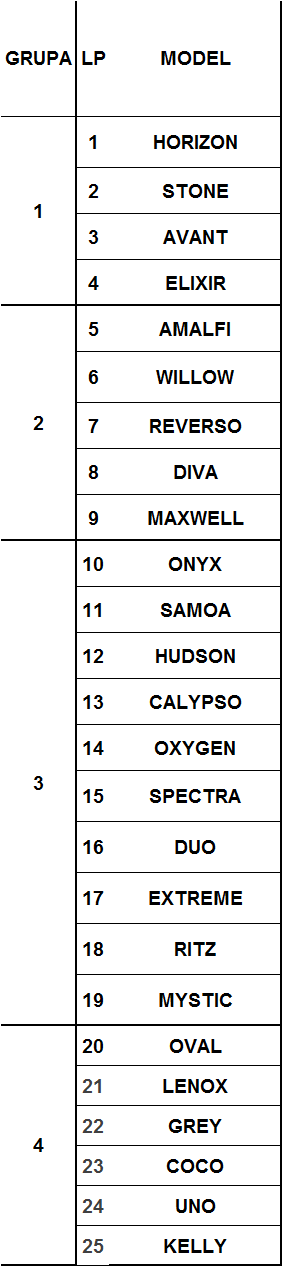

In [ ]:
ar=[Analiza_Rodziny(AMALFI_P),
    Analiza_Rodziny(AVANT_P),
    Analiza_Rodziny(CALYPSO),
    Analiza_Rodziny(COCO_PV),
    Analiza_Rodziny(DIVA),
    Analiza_Rodziny(DUO),
    Analiza_Rodziny(ELIXIR),
    # Analiza_Rodziny(EXTREME), #ZROBIC KLASE
    Analiza_Rodziny(GREY),
    Analiza_Rodziny(HUDSON),
    Analiza_Rodziny(HORIZON_PV),
    # Analiza_Rodziny(KELLY), #POPRAWIC KLASE!!!!
    Analiza_Rodziny(LENOX),
    Analiza_Rodziny(MAXWELL_P),
    # Analiza_Rodziny(MYSTIC), #NIE/ZROBIC KLASE?
    Analiza_Rodziny(ONYX),
    # Analiza_Rodziny(OVAL), #POPRAWIC KLASE!!!!
    Analiza_Rodziny(OXYGEN_P),
    Analiza_Rodziny(RITZ),
    Analiza_Rodziny(WILLOW),
    Analiza_Rodziny(REVERSO),
    Analiza_Rodziny(SPECTRA),
    Analiza_Rodziny(SAMOA),
    Analiza_Rodziny(UNO),
    Analiza_Rodziny(STONE_P)]

ar_podsum = pd.DataFrame([x.Raport() for x in ar])

In [ ]:
ard = {a.MODEL: a for a in ar}

In [ ]:
# ar_podsum[ar_podsum.columns[:-3]].sort_values(by="OBJ_BRYL_DO_ZAM_DO_OBJ_MAX")
ar_podsum.sort_values(by="OBJ_BRYL_DO_ZAM_DO_OBJ_MAX")

,MODEL,POZYCJE_ZAGROZONE,BRAKI,ILOSC_BRAKOW,BRYL_DO_ZAMOWIENIA,OBJ_BRYL_DO_ZAM_DO_OBJ_MAX,OBJ_CIECH,OBJ_VITA,OBJ_PIANPOL
18,SAMOA,0,0,0.0,5.0,0.017117,0.941845,0.000000,0.000000
5,DUO,0,0,0.0,22.0,0.022235,0.114615,0.678662,0.000000
9,HORIZON,9,1,15.0,87.0,0.056139,0.000000,15.064129,3.091670
17,SPECTRA,6,0,0.0,7.0,0.069740,3.565084,0.000000,0.000000
12,ONYX,1,0,0.0,19.0,0.078430,1.017600,3.711689,0.000000
0,AMALFI,9,4,23.0,63.0,0.079894,0.000000,0.000000,15.759760
14,RITZ,4,2,22.0,20.0,0.093160,1.987480,0.000000,0.000000
8,HUDSON,2,1,2.0,22.0,0.106457,5.330597,0.000000,0.000000
2,CALYPSO,4,1,10.0,34.0,0.113715,6.215025,0.000000,0.000000
15,WILLOW,5,0,0.0,77.0,0.123411,11.136255,7.497140,0.000000


In [ ]:
ar_podsum[["OBJ_CIECH",	"OBJ_VITA",	"OBJ_PIANPOL"]].sum()

OBJ_CIECH      114.396397
OBJ_VITA        82.608069
OBJ_PIANPOL    178.649437
dtype: float64

In [ ]:
_oao = Ogolna_analiza_objetosci(widok="podsum")
_oao[_oao.DO_ZAM_prc >= .2]

,SALDO_MAX_prc,WOLNE_MAX_prc,WOLNE_NIE_SPAK_MAX_prc,ZAM_I_WOLNE_prc,DO_ZAM_prc
RODZINA_NAZWA,,,,,
AVA,0.995349,0.802706,0.802706,0.802706,0.235959
COC,0.205263,-0.123684,0.402632,0.244737,0.228947
ELI,0.527481,0.265814,0.731073,0.265814,0.278562
EXT,1.647798,0.893423,0.893423,0.893423,0.453398
GRE,0.831250,0.556250,0.556250,0.556250,0.443750
KEL,0.787500,0.475000,0.475000,0.475000,0.525000
LEN,0.925919,0.731349,0.731349,0.731349,0.268651
MAX,0.623501,-0.023780,-0.023780,0.763929,0.253911
MYS,0.974763,0.861987,0.861987,0.861987,0.589117


In [ ]:
Wykres_propozycji_zamowien()

In [ ]:
def analiza_rodziny(rod):
  kol = ["OPIS", "ZAMOWIONE", "CZESIOWO_DOSTARCZONE", "CZEKA_NA_SPAKOWANIE", "SALDO", "SALDO_Z_NIE_SPAK", "MIN", "MAX", "ZLECENIA", "WST", "SUMA_ZLEC", "WOLNE_SALDO", "DO_ZAM_SZT"]
  ana_rod = analiza[analiza.RODZINA_NAZWA == rod][kol]
  return ana_rod

#BRYŁY DO ZAMÓWIENIA

In [ ]:
# Ogolna_analiza_objetosci("podsum")

In [ ]:
# @title BRYŁY DO ZAMÓWIENIA FUNKCJE
def bryly_do_zamowienia(klasa, analiza=analiza, wszystkie_bryly=False, zerowe_zam=False, lista_korety_zam = False, korekta_zam:dict=None):
  """
  klasa -> klasa rodziału pianek
  analiza -> DF z analiza zamówień
  wszytkie_bryly -> zwraca tabele z wszystkimi bryłami w analize
  zerowe_zam -> ustawia kolumne z zerowymi ilościami zamówienia dal wszytkich brył w analizie
  lista_korekty_zam -> zwraca dict z bryłami ustawionymi do zamówienia
  karekta_zam -> dict z poporawionymi ilościami zamówień brył, funkcja zwróci DF z bryłami z analizy oraz podsymowanie pianek do VITA
  """

  MODEL = klasa.MODEL

  if wszystkie_bryly:
    bdz = analiza[(analiza.RODZINA_NAZWA == MODEL[:3])][["KOD", "OPIS", "BRYLA_GEN", "DO_ZAM_SZT"]]
  else:
    bdz = analiza[(analiza.RODZINA_NAZWA == MODEL[:3]) & (analiza.DO_ZAM_SZT > 0)][["KOD", "OPIS", "BRYLA_GEN", "DO_ZAM_SZT"]]

  if zerowe_zam:
    bdz["zero_zam"] = 0
    return bdz[["KOD", "OPIS", "BRYLA_GEN", "zero_zam"]]

  if lista_korety_zam:
    return {i[1].BRYLA_GEN: i[1].DO_ZAM_SZT for i in bdz[["BRYLA_GEN", "DO_ZAM_SZT"]].iterrows()}

  if korekta_zam:
    kor = pd.DataFrame(korekta_zam.values(), columns=["KOREKTA_ZAM"], index=list(korekta_zam.keys())).reset_index().rename(columns={"index": "BRYLA_GEN"})
    kor_zam = bdz.merge(kor, how="right", on="BRYLA_GEN")[["KOD", "OPIS", "BRYLA_GEN", "KOREKTA_ZAM"]]
    bryly_kor_zam = {i[1].BRYLA_GEN: i[1].KOREKTA_ZAM for i in kor_zam[["BRYLA_GEN", "KOREKTA_ZAM"]].iterrows()}
    cls = klasa(bryly_kor_zam)
    print(cls)
    return kor_zam[[ "KOD", "OPIS",  "KOREKTA_ZAM"]].rename(columns={"KOREKTA_ZAM": "DO_ZAMOWIENIA"}), cls


  return bdz

def oblicz_owaty_do_zamowienia(*z_bdz):

  df_zam = pd.concat(z_bdz)
  df_zam = df_zam.merge(owaty, how="left", on="OPIS")

  for c in owaty.columns[1:]:
    df_zam[c] = df_zam[c] * df_zam.DO_ZAMOWIENIA

  return df_zam#[owaty.columns[1:]]


def zapotrzebowanie_na_owaty(zam_owaty, wyjatki:list):
  _wyjatki = pd.Series({"O3":0, "O2":0, "O1":0, "L1":0, "W3":0})
  for w in wyjatki:
    _wyjatki += w

  zap = zam_owaty[["O3", "O2", "O1", "L1", "W3"]].sum()+_wyjatki

  zap *= 1.1

  print(f"O1 zielona: {(zap['O1']/50).round(0):.0f} rolek")
  print(f"O2 niebieska: {(zap['O2']/40).round(0):.0f} rolek")
  print(f"O3 czerwona: {(zap['O3']/40).round(0):.0f} rolek")
  # return zap



def pobierz_zamowienie_z_ZAM_PIANKI(tydzien, _cls):
  _zam = zam_pianki[(zam_pianki.TYDZIEN == tydzien) & (zam_pianki.OPIS.str.contains(_cls.MODEL))].merge(komplety_pianek[["KOD", "BRYLA_GEN"]])[["OPIS", "BRYLA_GEN", "ILE_ZAMOWIONE"]]
  return _cls({i[1].BRYLA_GEN: i[1].ILE_ZAMOWIONE for i in _zam[["BRYLA_GEN", "ILE_ZAMOWIONE"]].iterrows()})



##KOMPONOWANIE ZAMOWIENIA

In [ ]:
zeli, eli = bryly_do_zamowienia(ELIXIR, wszystkie_bryly=True, korekta_zam={
    '2,5': 15.0,
#  '3': 0.0,
 '3,5': 30.0,
 '4': 50.0,
#  'N': 0.0,
#  '[': 0.0,
 'Pufa 98x120': 5.0,
 'Pufa 98x100': 10.0})

zsto, sto = bryly_do_zamowienia(STONE, wszystkie_bryly=True, korekta_zam={
    '1,5': 120.0,
 '2,5': 20.0,
 '3': 30.0,
#  '4': 2.0,
#  '5': 0.0,
#  'ON': 4.0,
#  'NW140x150': 0.0,
 '[LH': 15.0,
 'E30': 10,
 'P106x106': 10,
 'P106x82': 10.0,
#  'P82x82': 1.0,
 'STONE ][': 200.0})

eli+sto

In [ ]:
# zam 24/0216 tydzien 2407 ava 2_24, MAX 2_24, OXY 2_24
zoxy, oxy = bryly_do_zamowienia(OXYGEN_P, wszystkie_bryly=True, korekta_zam={
    '3': 40.0,
#  '3,5': 0.0,
 '4': 20.0,
#  'L': 0.0,
#  'N': 0.0,
#  '[L2H': 0.0,
#  'P103x103': 0.0,
#  'P103x80': 1.0,
#  '][': 0.0
                                                                 })
zmaxw, maxw = bryly_do_zamowienia(MAXWELL_P, wszystkie_bryly=True, korekta_zam={
    '1,5': 40.0,
 '3': 15.0,
#  '4': 0.0,
 'N': 10.0,
#  'ONs': 0.0,
 '[LH': 5.0,
 'P103x82': 10.0,
#  'P103x92': 0.0,
#  'P82x82': 0.0,
#  '][': 0.0
                                                                  })
zava, ava = bryly_do_zamowienia(AVANT_P, wszystkie_bryly=True, korekta_zam={
    # '[1]': 3.0,
#  '[2]': 0.0,
#  '[2,5]': 0.0,
 '[3]': 10.0,
#  '[3,5]': 0.0,
 '1': 15.0,
 '1,5': 15.0,
 '2': 5.0,
 '2,5': 10.0,
 '3': 10.0,
 '3,5': 10.0,
#  '1][': 15.0,
#  '1,5][': 0.0,
#  '2][': 0.0,
#  '2,5][': 5.0,
#  '3][': 15.0,
#  '3,5][': 10.0,
#  'N': 10.0,
 'L][': 40.0,
 'LM][': 10.0,
 'Pufa 104x64': 10.0,
#  'Pufa 112x84': 2.0,
 'Pufa 112x97': 20.0,
#  'Pufa 64x64': 4.0,
#  'Pufa 84x84': 1.0
    })

oxy+maxw+ava

OXYGEN Vol Pianpol: 16.45m3
MAXWELL Vol Pianpol: 23.36m3
AVANT Vol Pianpol: 42.69m3, AVANT Vol OLTA: 9.95m3


{'VITA': 0, 'CIECH': 0, 'PIANPOL': 82.50550000000001}

In [ ]:
ozn_owat

In [ ]:
zapotrzebowanie_na_owaty(oblicz_owaty_do_zamowienia(zava,zmaxw,zoxy),[])

pd.concat([zava,zmaxw,zoxy]).merge(
    oblicz_owaty_do_zamowienia(zava,zmaxw,zoxy)[["KOD", "O1", "O2", "O3", "L1","W3"]].fillna(0),
    how="left",
    on="KOD").rename(columns={"O1":"ZIELONA", "O2":"NIEBIESKA", "O3":"CZERWONA", "L1":"ŻÓŁTA"})#.to_excel("PIANPOL_2407.xlsx")

In [ ]:
ozn_owat

##DODANIE ZAMÓWIENIA DO BAZY

In [ ]:
pozycje = list()


def Dodaj_pozycje_do_ZAM_PIANKI(tydzien, zancznik_dostawcy, nr_kompletacji, modele:pd.DataFrame, klasa, zam1=None, zam2=None, nr_partii=None, DODAJ_DO_BAZY = False):

  model = klasa.MODEL
  galanteria = klasa.galanteria
  siedziska_HR = klasa.siedziska_HR
  leniwa = klasa.leniwa

  for r in modele.iterrows():
    # tydzien, model, kod, opis, ile_zam, znacznik_dostawcy, galanteria, siedziska_HR, leniwa, nr_kompletacji=None, zam1=None, zam2=None, nr_partii=None
    pozycje.append([tydzien, model, r[1].KOD, r[1].OPIS, r[1].DO_ZAMOWIENIA, zancznik_dostawcy, galanteria, siedziska_HR, leniwa, nr_kompletacji, zam1, zam2, "nr_partii: " + nr_partii])

  if DODAJ_DO_BAZY:

    for r in modele.iterrows():
      session.add(ZAM_PIANKI(tydzien, model, r[1].KOD, r[1].OPIS, r[1].DO_ZAMOWIENIA, zancznik_dostawcy, galanteria, siedziska_HR, leniwa, nr_kompletacji, zam1, zam2, "nr_partii: " + nr_partii))

    session.commit()

# zam 24/0216 tydzien 2407 ava 2_24, MAX 2_24, OXY 2_24
# Dodaj_pozycje_do_ZAM_PIANKI(2407, "P", "2_24", zava, ava, "24/0216", nr_partii="07/01,")#, DODAJ_DO_BAZY=True)
# Dodaj_pozycje_do_ZAM_PIANKI(2407, "P", "2_24", zmaxw, maxw, "24/0216", nr_partii="07/01,")#, DODAJ_DO_BAZY=True)
# Dodaj_pozycje_do_ZAM_PIANKI(2407, "P", "2_24", zoxy, oxy, "24/0216", nr_partii="07/01,")#, DODAJ_DO_BAZY=True)

pd.DataFrame(pozycje)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2407,AVANT,16.009.30003.60,AVANT [3],10.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
1,2407,AVANT,16.009.10000.60,AVANT 1,15.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
2,2407,AVANT,16.009.15000.60,"AVANT 1,5",15.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
3,2407,AVANT,16.009.20000.60,AVANT 2,5.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
4,2407,AVANT,16.009.25000.60,"AVANT 2,5",10.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
5,2407,AVANT,16.009.30000.60,AVANT 3,10.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
6,2407,AVANT,16.009.35000.60,"AVANT 3,5",10.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
7,2407,AVANT,16.009.63004.60,AVANT L][,40.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
8,2407,AVANT,16.009.64004.60,AVANT LM][,10.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"
9,2407,AVANT,16.009.70900.60,AVANT P104x64,10.0,P,P,P,O,2_24,24/0216,None,"nr_partii: 07/01,"


In [ ]:
with engine.begin() as conn:
  zam_pianki_db = pd.read_sql(text("SELECT * from ZAM_PIANKI"), conn)

zam_pianki_db[["LP", "TYDZIEN", "OPIS", "ILE_ZAMOWIONE", "ZNACZNIK_DOSTAWCY", "GALANTERIA", "SIEDZISKA_HR", "LENIWA", "ZAM1", "ZAM2", "UWAGI"]]

,LP,TYDZIEN,OPIS,ILE_ZAMOWIONE,ZNACZNIK_DOSTAWCY,GALANTERIA,SIEDZISKA_HR,LENIWA,ZAM1,ZAM2,UWAGI
0,1,2401,CALYPSO 1,20,C,C,C,C,24/0007,None,135
1,2,2401,CALYPSO 4,10,C,C,C,C,24/0007,None,None
2,3,2401,CALYPSO [LAD,10,C,C,C,C,24/0007,None,135
3,4,2401,CALYPSO [L2H,10,C,C,C,C,24/0007,None,None
4,5,2401,CALYPSO ][,60,C,C,C,C,24/0007,None,135
...,...,...,...,...,...,...,...,...,...,...,...
173,176,2406,HORIZON P102x62,15,PV,V,V,P,24/0186,24/0187,nr_partii: 2
174,177,2406,HORIZON P82x82,15,PV,V,V,P,24/0186,24/0187,nr_partii: 2
175,178,2406,HORIZON ][,110,PV,V,V,P,24/0186,24/0187,nr_partii: 2
176,179,2406,COCO [1M],20,PV,V,V,P,24/0186,24/0187,nr_partii: 2


In [ ]:
zp = zam_pianki[(zam_pianki.spakowana !=1)&(zam_pianki.NR_KOMPLETACJI != "")&(zam_pianki.NR_KOMPLETACJI != "BRAK")]
zp[zp.OPIS.str.contains("OXY")]

In [ ]:
# session.add(ZAM_PIANKI())

#RAPORTY DO ZAMÓWIENIA

In [ ]:
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side
from datetime import datetime as dt

In [ ]:
def zlecenia_produkcyjne_pianki_owaty(model, nr_kompletacji, nr_partii):
  """
  nr_partii -> numer tygodnia / np.: 07/1
  """
  zp = zam_pianki[(zam_pianki.OPIS.str.contains(model))&(zam_pianki.NR_KOMPLETACJI == nr_kompletacji)][["OPIS", "ILE_ZAMOWIONE"]]

  for p in range(zp.shape[0]):

    ow = _owaty[_owaty.OPIS == zp.iloc[p].OPIS][["TYP_OWATY", "ZUZYCIE", "RODZAJ_CIECIA", "NAZWA_UKL"]].reset_index()
    ow["ZUZYCIE"] = ow.ZUZYCIE*zp.iloc[p].ILE_ZAMOWIONE*1.1
    ow["KATER_UKL"] = ow.apply(lambda x: x.NAZWA_UKL if x.RODZAJ_CIECIA == "K" else "", axis=1)

    wb = openpyxl.Workbook()
    sheet = wb.active

    sheet["A1"] = "ZLECENIE PRODUKCYJNE: WYDZIAŁ ROZKRÓJ OWAT / KOMPLETACJA OWATY"
    sheet["A3"] = f"NR PARTII: {nr_partii}"
    sheet["A4"] = f"NR ZAMÓWIENIA: {model} {nr_kompletacji}"
    sheet["A5"] = f"MODEL: {model}"
    sheet["H1"] = f"DZIEŃ WYDRUKU      {dt.now().strftime('%Y-%m-%d')}"
    sheet["E4"] = "TYP"
    sheet["F4"] = "MB"
    sheet["G4"] = "R/K"
    sheet["H4"] = "KATER_UKL"

    start_row = 5
    for r in ow.iterrows():

      sheet.cell(row=r[0]+start_row, column=5, value=r[1].TYP_OWATY)
      sheet.cell(row=r[0]+start_row, column=6, value=r[1].ZUZYCIE)
      sheet.cell(row=r[0]+start_row, column=7, value=r[1].RODZAJ_CIECIA)
      sheet.cell(row=r[0]+start_row, column=8, value=r[1].KATER_UKL)


    sheet["A15"] = "BRYŁA"
    sheet["B15"] = "ILOŚĆ PACZEK"
    sheet["C15"] = "CZAS"
    sheet["A16"] = zp.iloc[p].OPIS
    sheet["B16"] = zp.iloc[p].ILE_ZAMOWIONE

    sheet["A18"] = "UWAGI:"
    sheet["H18"] = "PODPIS, DZIEN:"

    thin = Side(border_style="thin", color="000000")
    for row in sheet[f"E4:i{ow.shape[0]+4}"]:
        for cell in row:
          cell.border = Border(bottom=thin)

    wb.save(f"OWATY {model} {nr_kompletacji} {zp.iloc[p].OPIS.replace(model, '')}.xlsx")



In [ ]:
!rm -f *.xlsx

In [ ]:
zlecenia_produkcyjne_pianki_owaty("AVANT", "2_24", "07/01")

In [ ]:
# @title RAPORTY DO ZAMÓWIENIA FUNKCJE

def specyfikacja_zam_vita_xlsx(NR_zam:str, raport_vita:pd.DataFrame):
  wb = openpyxl.Workbook()
  sheet = wb.active

  sheet["B1"] = f"SPECYFIKACJA ZAMÓWIENIE DOS/{NR_zam}"
  sheet["H1"] = dt.now().strftime("%Y-%m-%d")
  sheet["B3"] = "Zamawiajacy"
  sheet["B4"] = "OLTA K.K. Zawistowscy sp. j"
  sheet["B5"] = "Ignatki 40/6"
  sheet["B6"] = "16-001 Kleosin"
  sheet["B7"] = "NIP 966 14 08 783"
  sheet["H3"] = "Dostawca"
  sheet["H4"] = "VITA POLYMERS POLAND SP. Z O.O."
  sheet["A8"] = "LP"
  sheet["I8"] = "UWAGI"

  rows = dataframe_to_rows(raport_vita)
  for r_idx, row in enumerate(rows, 1):
      for c_idx, value in enumerate(row, 1):
          sheet.cell(row=r_idx+7, column=c_idx, value=value)

  thin = Side(border_style="thin", color="000000")
  for row in sheet[f"A9:i{raport_vita.shape[0]+9}"]:
      for cell in row:
        cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)

  wb.save(f"SPECYFIKACJA DO ZAMÓWIENIA DOS {' '.join(NR_zam.split('/'))}.xlsx")

def raport_vita(*args):
  """
  Zesatwaienie zamówionych pianek do VITA ilośiowe i z podziałem na bryły
  """


  pianki = [x.vita for x in args]
  zam_pianek_vita = pd.concat(pianki).fillna("")[["TYP", "NUMER", "ilosc", "PROFIL", "OZN", "OPIS", "WYMIAR"]]
  zam_pianek_vita.set_index(pd.Index([x for x in range(1,zam_pianek_vita.shape[0]+1)]),inplace=True)

  podsumowanie_zamowienia_vita = pd.concat(pianki).fillna("").sort_values(by="NUMER")
  podsumowanie_zamowienia_vita.set_index(pd.Index([x for x in range(1,podsumowanie_zamowienia_vita.shape[0]+1)]),inplace=True)



  return zam_pianek_vita, podsumowanie_zamowienia_vita[["TYP", "NUMER", "ilosc", "PROFIL", "OZN", "OPIS", "WYMIAR"] + [x for x in podsumowanie_zamowienia_vita.columns if "br" in x]]


def raport_dostarczonych_pianek(cls, drukuj_excel=False):
  """
  Zesatwianie ilosci pianek do modelu z dostawy
  komplety_pianek -> df z kopletami pianek
  cls -> zinicjalizowana instacja klasy zawierająca odpowiedni model
  """
  zestawienie_pianek_do_bryly = list()

  for br in cls.bryly.keys():
    df = tab[(tab.MODEL == cls.MODEL) & (tab.BRYLA == br)]
    df["ILOŚĆ"] = (df.ilosc * cls.bryly[br]).astype(int)
    df["DOSTARCZONO/UWAGI"] = ""
    df = df[['TYP', 'PRZEZ', 'OR', 'OZN', 'PROFIL', 'NUMER', 'WYMIAR', 'ILOŚĆ', 'DOSTARCZONO/UWAGI']].fillna("-")
    df.set_index(pd.Index([x for x in range(1,df.shape[0]+1)]),inplace=True)
    zestawienie_pianek_do_bryly.append([br, df])

  def drukuj_zestawienie_dla_bryly_xlsx(zpdb_n):
    _df = zpdb_n[1]
    _df = _df[_df.TYP != "G-401"]
    header = f"{cls.MODEL} {zpdb_n[0]} - {cls.bryly[zpdb_n[0]]:.0f}szt"
    print(header)
    wb = openpyxl.Workbook()
    sheet = wb.active
    sheet.oddHeader.left.text = header
    sheet.oddHeader.left.size = 18
    sheet.oddHeader.left.font = "Calibry,Bold"
    # sheet.oddHeader.right.text = "Data dostawy:            \nNr dostawy:           "
    sheet.append(["LP"]+list(_df.columns))
    rows = dataframe_to_rows(_df,header=False)
    for r in list(rows)[1:]:
      sheet.append(r)

    thin = Side(border_style="thin", color="000000")
    sheet.page_setup.orientation = sheet.ORIENTATION_LANDSCAPE
    for row in sheet[f"A1:J{_df.shape[0]+1}"]:
      for cell in row:
        cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)

    wb.save(f"{cls.MODEL[:3]} {zpdb_n[0]}.xlsx")

  if drukuj_excel:
    for i in zestawienie_pianek_do_bryly:
      drukuj_zestawienie_dla_bryly_xlsx(i)
    return 0

  return zestawienie_pianek_do_bryly

In [ ]:
# specyfikacja_zam_vita_xlsx("23/1411")

In [ ]:
wil = WILLOW({'1':15,
 '1,5':10,
 '2,5':10,
#  '4',
 '[':100,
 ']':100,
 '[L':10,
 '[L2Hz': 40,
#  'N',
#  'P106x106',
#  'P82x106',
#  'P82x82'
 })

In [ ]:
r = raport_vita(wil)

In [ ]:
r[0]

,TYP,NUMER,ilosc,PROFIL,OZN,OPIS,WYMIAR
1,HR-3020,EB0417,200,,prosta,siedzisko,140x190x190
2,HR-3020,EB0419,20,,format,siedzisko,140x790x910
3,HR-3020,EB0420,10,,prosta,siedzisko,140x190x670
4,HR-3020,EB0421,10,,prosta,siedzisko,140x610x910
5,HR-3020,EB0422,10,,prosta,siedzisko,140x110x170
6,HR-3020,EB0426,15,,format,siedzisko,140x790x810
7,HR-3020,EB0428,20,,format,siedzisko,140x790x710
8,HR-3020,EB0429,40,,prosta,siedzisko,140x540x1140
9,HR-3020,EB0430,40,,format,siedzisko,140x820x900
10,HR-3020,EB0431,40,,format,siedzisko,140x800x800


In [ ]:
specyfikacja_zam_vita_xlsx("24/0187",r[0])

In [ ]:
r[1].to_excel("ZESTAWIENIE PIANEK DO ZAMOWIENIA DOS 24_0187.xlsx")

In [ ]:
raport_dostarczonych_pianek(wil, drukuj_excel=True)

WILLOW 1 - 15szt
WILLOW 1,5 - 10szt
WILLOW 2,5 - 10szt
WILLOW [ - 100szt
WILLOW ] - 100szt
WILLOW [L - 10szt
WILLOW [L2Hz - 40szt


0

In [ ]:
raport_dostarczonych_pianek(coc, drukuj_excel=True)

COCO [1M] - 20szt
COCO [1o] - 40szt


0

In [ ]:
# raport_dostarczonych_pianek(hor, drukuj_excel=True)

#ANALIZA DOSTAW

In [ ]:
# dos_ciech = zam_pianki[(zam_pianki.ZAM1.str.contains("23/1406|23/1416")) & (zam_pianki.dostarczono == 0)][["KOD", "OPIS", "ILE_ZAMOWIONE"]]
# dos_ciech = dos_ciech.merge(komplety_pianek[['KOD','BRYLA_GEN', 'obj', 'RODZINA_NAZWA']], how="left", on="KOD")

rodzina_nazwa_klasa = {'ONY':ONYX, 'RIT':RITZ, 'REV':REVERSO, 'WIL':WILLOW, 'HOR':HORIZON, 'OXY':OXYGEN, 'AMA':AMALFI, 'CAL': CALYPSO, 'DIV': DIVA,
                       'DUO': DUO, 'ELI': ELIXIR, 'HUD': HUDSON, 'STO': STONE, }


In [ ]:
def pobierz_zamowienie_z_DOS_VITA(num_dos_vita:str, lista_modeli=True, objetosc_modeli=False):
  """
  num_dos_vita -> numety dostaw z ciech w pliku ZAM_PIANKI rozdzielone '|' (filtr str.contains)
  """
  dos_vita = zam_pianki[(zam_pianki.ZAM2.str.contains(num_dos_vita)) & (zam_pianki.dostarczono == 0)][["KOD", "OPIS", "ILE_ZAMOWIONE"]]
  dos_vita = dos_vita.merge(komplety_pianek[['KOD','BRYLA_GEN', 'obj', 'RODZINA_NAZWA']], how="left", on="KOD")
  dos_vita["obj_bryly"] = dos_vita.ILE_ZAMOWIONE * dos_vita.obj


  lista_model = list()
  for n in list(dos_vita.RODZINA_NAZWA.unique()):
    _cls = rodzina_nazwa_klasa[n]
    _zam = dos_vita[(dos_vita.OPIS.str.contains(_cls.MODEL))].merge(komplety_pianek[["KOD", "BRYLA_GEN"]])[["OPIS", "BRYLA_GEN", "ILE_ZAMOWIONE"]]
    lista_model.append(_cls({i[1].BRYLA_GEN: i[1].ILE_ZAMOWIONE for i in _zam[["BRYLA_GEN", "ILE_ZAMOWIONE"]].iterrows()}))

  if lista_modeli:
    return lista_model
  elif lista_modeli == False and objetosc_modeli == True:
    return{num_dos_vita: {x.MODEL: x.vita_VOL for x in lista_model}}
  else:
    sum_ciech = 0
    for m in lista_model:
      sum_ciech += m.vita_VOL

    _dos = dos_vita[["OPIS", "ILE_ZAMOWIONE", "obj_bryly"]]
    #dodanie levelu do nazw column z numerem dostawy
    _dos.columns = pd.MultiIndex.from_product([[num_dos_vita], _dos.columns])
    return sum_ciech, _dos

In [ ]:
def pobierz_zamowienie_z_DOS_CIECH(num_dos_ciech:str, lista_modeli=True, objetosc_modeli=False):
  """
  num_dos_ciech -> numety dostaw z ciech w pliku ZAM_PIANKI rozdzielone '|' (filtr str.contains)
  """
  dos_ciech = zam_pianki[(zam_pianki.ZAM1.str.contains(num_dos_ciech)) & (zam_pianki.dostarczono == 0)][["KOD", "OPIS", "ILE_ZAMOWIONE"]]
  dos_ciech = dos_ciech.merge(komplety_pianek[['KOD','BRYLA_GEN', 'obj', 'RODZINA_NAZWA']], how="left", on="KOD")
  dos_ciech["obj_bryly"] = dos_ciech.ILE_ZAMOWIONE * dos_ciech.obj


  lista_model = list()
  for n in list(dos_ciech.RODZINA_NAZWA.unique()):
    _cls = rodzina_nazwa_klasa[n]
    _zam = dos_ciech[(dos_ciech.OPIS.str.contains(_cls.MODEL))].merge(komplety_pianek[["KOD", "BRYLA_GEN"]])[["OPIS", "BRYLA_GEN", "ILE_ZAMOWIONE"]]
    lista_model.append(_cls({i[1].BRYLA_GEN: i[1].ILE_ZAMOWIONE for i in _zam[["BRYLA_GEN", "ILE_ZAMOWIONE"]].iterrows()}))

  if lista_modeli:
    return lista_model
  elif lista_modeli == False and objetosc_modeli == True:
    return{num_dos_ciech: {x.MODEL: x.ciech_VOL for x in lista_model}}
  else:
    sum_ciech = 0
    for m in lista_model:
      sum_ciech += m.ciech_VOL

    _dos = dos_ciech[["OPIS", "ILE_ZAMOWIONE", "obj_bryly"]]
    #dodanie levelu do nazw column z numerem dostawy
    _dos.columns = pd.MultiIndex.from_product([[num_dos_ciech], _dos.columns])
    return sum_ciech, _dos


In [ ]:
obj_dos_vita = [pobierz_zamowienie_z_DOS_VITA("23/1411", lista_modeli=False),]


In [ ]:
obj_dos_ciech = [pobierz_zamowienie_z_DOS_CIECH("23/1406|23/1416", lista_modeli=False),
      pobierz_zamowienie_z_DOS_CIECH("23/1486",lista_modeli=False),
      pobierz_zamowienie_z_DOS_CIECH("23/1517", lista_modeli=False)]

In [ ]:
sum = 0
for vv in [pobierz_zamowienie_z_ZAM_PIANKI(2350, DUO),
          pobierz_zamowienie_z_ZAM_PIANKI(2350, ELIXIR),
           pobierz_zamowienie_z_ZAM_PIANKI(2350, ONYX)]:
  sum += vv.vita_VOL
  print(vv.MODEL, vv.vita_VOL)
print(sum)

In [ ]:
for d in obj_dos_vita:
  print(d[0])

In [ ]:
for d in obj_dos_ciech:
  print(d[0])

In [ ]:
l_ciech = [pobierz_zamowienie_z_DOS_CIECH("23/1406|23/1416", lista_modeli=False, objetosc_modeli=True),
      pobierz_zamowienie_z_DOS_CIECH("23/1486",lista_modeli=False, objetosc_modeli=True),
      pobierz_zamowienie_z_DOS_CIECH("23/1517", lista_modeli=False, objetosc_modeli=True)]


In [ ]:
l_ciech[2]

In [ ]:
from datetime import timedelta

In [ ]:
aktywne_dos = pd.read_excel("drive/MyDrive/ZAM_PIANKI.xlsx", sheet_name="AKTYWNE_DOS")

In [ ]:
aktywne_dos.columns

In [ ]:
aktywne_dos.info()

In [ ]:
aktywne_dos["ZAM"] = aktywne_dos["Nr zam."].str.replace("DOS/", "")
aktywne_dos["data_dos"] = aktywne_dos['Data dostawy'] + timedelta(1)

def nazwa_dostawcy(x):
  if "PIANPOL" in x:
    return "PIANPOL"
  if "VITA" in x:
    return "VITA"
  if "CIECH" in x:
    return "CIECH"

aktywne_dos["Dostawca"] = aktywne_dos["Dostawca opis"].apply(nazwa_dostawcy)

In [ ]:
aktywne_dos.sort_values(by="Data dostawy")

In [ ]:
fig = px.timeline(aktywne_dos, x_start="Data dostawy", x_end="data_dos", y="Dostawca", title="Dostaway pianek", text="ZAM",  color="Dostawca")#, hover_data=["Opis"])
fig.add_vline(x=dt.now(), line_width=.5, line_color="blue")
fig.update_yaxes(autorange="reversed")
fig.show()

In [ ]:
samochod = {
    # "2023-12-21 PIANPOL": "23/1404",

    "2024-01-12 CIECH": '23/1406|23/1416',
    "2024-01-15 CIECH": '23/1486',
    "2024-01-23 CIECH": '23/1517'
}
samochod

In [ ]:
l = [pobierz_zamowienie_z_DOS_CIECH("23/1406|23/1416", lista_modeli=False, objetosc_modeli=True),
      pobierz_zamowienie_z_DOS_CIECH("23/1486",lista_modeli=False, objetosc_modeli=True),
      pobierz_zamowienie_z_DOS_CIECH("23/1517", lista_modeli=False, objetosc_modeli=True)]

In [ ]:
l[0].items()

In [ ]:
import pandas as pd
import plotly.express as px

In [ ]:
lista_samochodow = [
    ["2023-12-21 SAM 1", "PIANPOL", "1 AVANT", 70],
    ["2023-12-21 SAM 1", "PIANPOL", "BLOK AA T-2538", 20],
    ["2024-01-09 SAM 2", "VITA", "2 ONYX", 13],
    ["2024-01-09 SAM 2", "VITA", "4 REVERSO", 19],
    ["2024-01-09 SAM 2", "VITA", "5 WILLOW", 4],
    ["2024-01-09 SAM 2", "VITA", "6 HORIZON", 10],
    ["2024-01-09 SAM 2", "VITA", "7 OXYGEN", 5],
    ["2024-01-09 SAM 2", "VITA", "8 STONE", 30],
    ["2024-01-11 SAM 3", "PIANPOL", "9 AVANT", 90],
    ["2024-01-12 SAM 4", "CIECH", "2 ONYX", 1],
    ["2024-01-12 SAM 4", "CIECH", "3 RITZ", 16],
    ["2024-01-12 SAM 4", "CIECH", "4 REVERSO", 21],
    ["2024-01-12 SAM 4", "CIECH", "5 WILLOW", 6],
    ["2024-01-12 SAM 4", "CIECH", "6 HORIZON", 2],
    ["2024-01-12 SAM 4", "CIECH", "7 OXYGEN", 8],
    ["2024-01-15 SAM 5", "CIECH", "10 AMALFI", 46],
    ["2024-01-15 SAM 5", "CIECH", "11 REVERSO", 50],
    ["2024-01-15 SAM 5", "CIECH", "12 ONYX", 3],
    ["2024-01-16 SAM 6", "VITA", "10 AMALFI", 35],
    ["2024-01-16 SAM 6", "VITA", "11 REVERSO", 43],
    ["2024-01-16 SAM 6", "VITA", "12 ONYX", 10],
    ["2024-01-22 SAM 7", "CIECH", "14 DIVA", 2],
    ["2024-01-22 SAM 7", "CIECH", "13 CALYPSO", 5],
    ["2024-01-22 SAM 7", "CIECH", "15 DUO", 4],
    ["2024-01-22 SAM 7", "CIECH", "16 ELIXIR", 70],
    ["2024-01-22 SAM 7", "CIECH", "17 HUDSON", 4],
    ["2024-01-22 SAM 7", "CIECH", "18 ONYX", 4],
    ["2024-01-24 SAM 8", "VITA", "15 DUO", 16],
    ["2024-01-24 SAM 8", "VITA", "16 ELIXIR", 53],
    ["2024-01-24 SAM 8", "VITA", "18 ONYX", 15],
]

df = pd.DataFrame(lista_samochodow, columns=["SAMOCHOD", "DOSTAWCA", "MODEL", "obj"])
# df

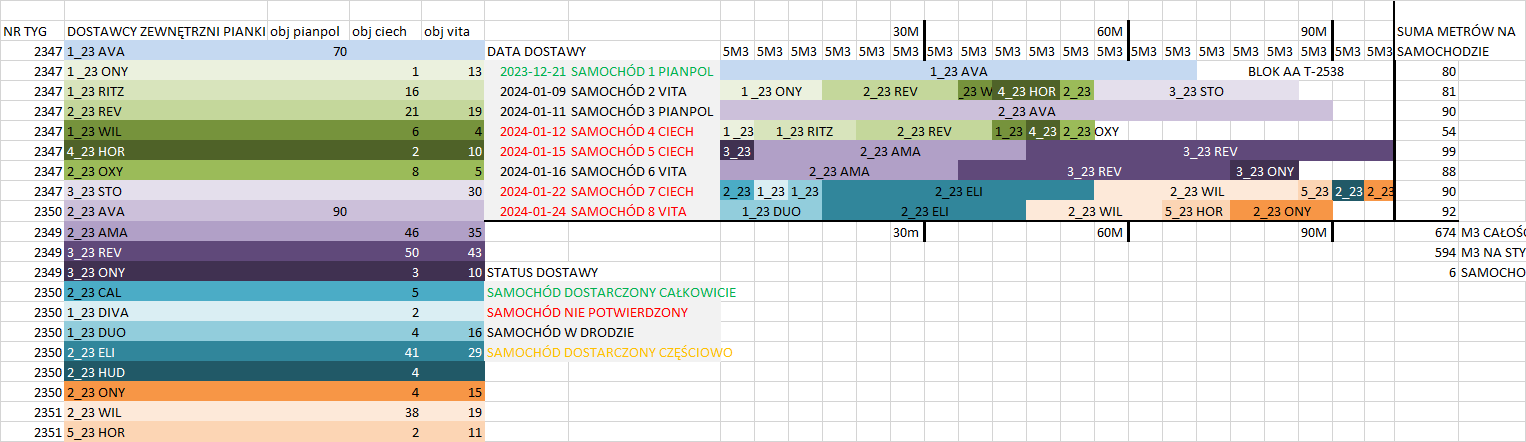

In [ ]:
fig = px.bar(df.sort_values(by="SAMOCHOD"), x="obj", y="SAMOCHOD", color='MODEL', orientation='h',
             text="MODEL",
             hover_data=["DOSTAWCA"],
            #  height=400,
             title='Zapełnienie samochodów 2023-12-20')
fig.update_yaxes(autorange="reversed")
fig.add_vline(x=30)
fig.add_vline(x=60)
fig.add_vline(x=90)
# fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()